=== GENERAL TODO'S:
                                       -|=======|=======|+
* Data read                                     ?
    * ~~Static~~                                        [done]
    * ~~Refrred to dicom fields~~                       [done]
    * Dynamic                                           [done]
        * interpolable                                  [done]
            * optimalization            [optional]
            * bicubic                   [optional]        
* Patchification system                         ?
    * ~~Static~~                                        [done]
    * Update-able                               [wip]
* Vascular segmentation                         [wip]
    * Linear kernel application                 [wip]
    * Canny                             [concept]
    * Canny -> Hull                     [concept]
    * Hull -> Mask                      [concept]
    * Mask -> Skel                      [concept]
    + CNN?                              [reluctant]
* Vascular positioning                          ?
    * Vascular skel model               [concept]
    * Vascular skel discrimination      [concept]
    * Characteristic points estim       [concept]
* Visualisation
    * ~~Mango-like~~                                    [done]
        * Efficient                     [concept]
    * Rotable                           [concept]

python3 -m pip install cupy-cuda110


tdsp = r"../AngioCT tt szyjnych/4/AQWS01_10.7.112.230_20220525111102552/1.3.12.2.1107.5.1.4.105397.30000021102806505454700023291/1.3.12.2.1107.5.1.4.105397.30000021102806505454700023292.dcm"

In [1]:
import pydicom
import matplotlib.pyplot as plt
import glob
# import re
# import os
# import patchify
from tqdm import tqdm
import cv2
import datetime

import numpy as np
import cupy as cp
na                  = np.asarray
xm = {
    np:             (np.asarray, np.asarray, np.asarray, np),
    cp:             (cp.asarray, cp.asnumpy, cp.asarray, cp),
}  # (da, ha, xa, xp)


In [171]:
tdsp = r"../AngioCT tt szyjnych/4/AQWS01_10.7.112.230_20220525111102552/1.3.12.2.1107.5.1.4.105397.30000021102806505454700023291/*"
ds_path_l = glob.glob(tdsp)

ds_l = [pydicom.dcmread(ds_path) for ds_path in ds_path_l]
dsa  = na([ds.pixel_array for ds in ds_l[::-1]])

# for ds in ds_l:
#     print(ds.AcquisitionTime)

# https://pydicom.github.io/pydicom/stable/auto_examples/image_processing/reslice.html#sphx-glr-auto-examples-image-processing-reslice-py
ds = ds_l[2]
ds.dir

# %todo: parametrize spacing (slice thickness)

# sx - slice x
# cx - cube x

## Image plane
# (0018, 0050) Slice Thickness                     DS: '0.6'                                            # [mm]                  Nominal slice thickness.            # https://dicom.innolitics.com/ciods/ct-image/image-plane/00180050
# (0020, 1041) Slice Location                      DS: '-28.5'+                                         # [mm] cz               
# (0028, 0030) Pixel Spacing                       DS: [0.416015625, 0.416015625]                       # [mm] *s(x, y)         (intuitive),                        # https://dicom.innolitics.com/ciods/ct-image/image-plane/00280030        
# (0020, 0032) Image Position (Patient)            DS: [-98.2919921875, -270.2919921875, -28.5]         # [mm]                  first image upper left corner       # https://dicom.innolitics.com/ciods/ct-image/image-plane/00200032
# (0020, 0037) Image Orientation (Patient)         DS: [1, 0, 0, 
#                                                       0, 1, 0]                                        # s2c(x, y, z) *s(x, y) projection mx cosines               # https://dicom.innolitics.com/ciods/ct-image/image-plane/00200037

##
# (0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
# (0018, 9313) Data Collection Center (Patient)    FD: [0.0, -164.0, -28.5]
# (0018, 9318) Reconstruction Target Center (Patie FD: [8.0, -164.0, -28.5]
# (0028, 1050) Window Center                       DS: [105, 250]
# (0028, 1051) Window Width                        DS: [765, 500]
# (0028, 1052) Rescale Intercept                   DS: '-1024.0'
# (0028, 1053) Rescale Slope                       DS: '1.0'

## Time
# (0008, 0032) Acquisition Time                    TM: '111515.611000'


<bound method Dataset.dir of Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 212
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.16.840.1.113669.632.21.1635916553.279322404.391980493922060650
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 2.16.840.1.113669.632.21.1
(0002, 0013) Implementation Version Name         SH: 'AQNET430-370IB5'
(0002, 0016) Source Application Entity Title     AE: ''
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID         

In [3]:
## draft
# dslice = pydicom.dcmread(ds_path_l[0])
# type(dslice.PixelSpacing)

# e = np.ogrid[1:3, 0:2]
# e[0].all(axis=1)

# na([[1, 2]]) + na([[3],[0]])

array([[4, 5],
       [1, 2]])

In [4]:
## CODE > PATCHIFY
na = np.asarray

def pad_patchify(
        input_array: np.ndarray,                                ##(*bdim, *pdim) 
        padded_patch_shape,                                     ##(             pdim)
        pad_shape,                                              ##({shu+shr},   pdim)
        input_crop_shape,                                       ##({shu+shr},   pdim)
        patch_excess_min,                                       ##(             pdim)
        pad_mode="edge",                                        # numpy.pad(mode=)
        tv = None,                                           # str
):
    pdim    = padded_patch_shape.__len__()                      # patch dimensions no
    bdim    = input_array.shape.__len__() - pdim                # batch dimensions no

    ## calc actual lower padding (not being covered by crop margin)
    pad_shl,  pad_shr   = na(pad_shape)                         # shl, shu, shr = shape [span] lower, upper, rearwards
    crop_shl, crop_shr  = na(input_crop_shape)        
    arr2opa_shl         = crop_shl - pad_shl                    # position of opa's i0 relative to array (consider it vec); opa = outer-padded array
    opa2arr_shl         = pad_shl - crop_shl                    # postition of array's i0 relative to opa
    arr_crop_shl        = np.maximum(0, arr2opa_shl)            # reduce input cropping if no enough crop to satisfy padding
    opa_pad_shl         = np.maximum(0, opa2arr_shl)            # pad needing artificial fulfilling as not being covered by cropped image

    ## calc how much patches will be there  
    array_sh            = na(input_array.shape[ bdim:])
    crarr_sh            = array_sh - (crop_shl + crop_shr)      # crarr = cropped_array
    pdp_sh              = na(padded_patch_shape)                # pdp = padded_patch
    upd_sh              = pdp_sh - (pad_shl+pad_shr)            # upd = unpadded[_patch]
    patch_step          = upd_sh                                # step between 0th elements of consecutive patches
    upd_ex_min_sh       = na(patch_excess_min)
    pgrid_sh, pex_rm_sh = np.divmod(crarr_sh, patch_step)
    pex_accept          = pex_rm_sh >= upd_ex_min_sh
    pgrid_sh            = pgrid_sh + pex_accept

    ## calc opa upper padding
    opa_sh              = (pgrid_sh * upd_sh) + (pad_shl + pad_shr)
    arr2opa_shu         = arr2opa_shl + opa_sh 
    opa2arr_shu         = opa2arr_shl + array_sh
    arr_crop_shu        = np.minimum(array_sh, arr2opa_shu)
    opa_pad_shu         = np.minimum(opa_sh,   opa2arr_shu)
    opa_pad_shr         = opa_sh - opa_pad_shu

    ## quick checks
    assert np.all(upd_sh > 0)                                   # is patch containing anything beside patch
    assert np.all(upd_ex_min_sh <= upd_sh)                      # is patch_excess_min positive
    assert np.all(pgrid_sh > 0)                                 # is possible to create at least one patch (by input shape, patch shape, patch excess)

    ## opa = input crop & outer-pad
    batch_sh            = na(input_array.shape[:bdim ])
    batch_all           = (slice(None),)    *bdim
    batch_pad           = (0,)              *bdim
    input_crop          = tuple(slice(aclx, acux)   for aclx, acux in zip(arr_crop_shl, arr_crop_shu))
    opa                 = np.pad(
                                        input_array[batch_all + input_crop], 
                            pad_width=  na((
                                            batch_pad + tuple(opa_pad_shl), 
                                            batch_pad + tuple(opa_pad_shr))).T, 
                            mode=       pad_mode) # type: ignore
    
    ## patchify
    patch_array         = np.zeros(())
    pgrid_og            = np.ogrid[tuple(slice(pgsx) for pgsx in pgrid_sh)]
    patch_og            = np.ogrid[tuple(slice(pasx) for pasx in pdp_sh)]
    pg2pa_og            = tuple(
                                (pgogx * pstepx)[(slice(None),) *pdim   + (None,)           *pdim] 
                            +   paogx           [(None,)        *pdim   + (slice(None),)    *pdim] 
                            for     pgogx,      pstepx,     paogx 
                            in zip( pgrid_og,   patch_step, patch_og))
    
    for _ in tqdm((None,), desc=f"{tv} [PBX={pgrid_sh.prod()}]", disable=not tv):
        patch_array     = opa[batch_all + pg2pa_og]

    ## save info about actual shape for merging
    pgrid_shape         = tuple(pgrid_sh)
    pex_crop_shr        = (upd_sh - pex_rm_sh) * pex_accept
    array_shape         = (pgrid_sh * upd_sh) - pex_crop_shr

    return patch_array, pgrid_shape, array_shape


def pad_unpatchify(
        patch_array: np.ndarray,
        padded_patch_shape,
        pad_shape,
        array_shape,
        tv = None
):
    pdim                = padded_patch_shape.__len__()
    bdim                = patch_array.shape.__len__() - (pdim *2)

    ## calc pads
    pdp_sh              = na(padded_patch_shape)
    pad_shl,  pad_shr   = na(pad_shape)
    upd_sh              = pdp_sh - (pad_shl+pad_shr)
    patch_step          = upd_sh

    pad_shu             = pdp_sh - pad_shr
    pgrid_shape         = patch_array.shape[bdim:-pdim]
    pgrid_sh            = na(pgrid_shape)

    ## unpatchify
    batch_shape         = patch_array.shape[:bdim ]
    batch_all           = (slice(None),) *bdim
    unpad_crop          = (slice(None),) *pdim + tuple(slice(pshlx, pshux) for pshlx, pshux in zip(pad_shl, pad_shu))
    pgrid_og            = np.ogrid[tuple(slice(pgsx) for pgsx in pgrid_sh)]
    patch_og            = np.ogrid[tuple(slice(pasx) for pasx in upd_sh)]
    pg2pa_og            = tuple(
                                (pgogx * pstepx)[(slice(None),) *pdim   + (None,)           *pdim] 
                            +   paogx           [(None,)        *pdim   + (slice(None),)    *pdim] 
                            for     pgogx,      pstepx,     paogx 
                            in zip( pgrid_og,   patch_step, patch_og))

    ## merge
    output_array_ex_sh  = pgrid_sh * upd_sh
    output_array_ex     = np.zeros((*batch_shape, *output_array_ex_sh), dtype=patch_array.dtype)

    for _ in tqdm((None,), desc=f"{tv} [PBX={pgrid_sh.prod()}]", disable=not tv):
        output_array_ex[batch_all + pg2pa_og] = patch_array[batch_all + unpad_crop]

    ## discard excess
    output_array_sh     = array_shape
    output_array        = output_array_ex[tuple(slice(osx) for osx in output_array_sh)]

    return output_array


def batchify(
        pbatch_iter,                                            ##(bdim*p[g]dim, pdim)
        patch_shape,                                            ##(pdim)
        umem_pool,                                                # bytes / type.nbytes
        umem_poly,                                               # (1, root(pdim, mlt(patch_sh)), root(pdim, mlt(patch_sh)**2), ..., ) | %todo
        tv=None,
        xp=np,
):
    ## batch_size calc
    pdim                = patch_shape.__len__()
    umem_poly           = na(umem_poly)

    if  umem_poly.shape.__len__() == 1:                     # convert linear polynomial to dimensional one
        umem_poly_lin       = umem_poly
        umem_poly_lin_l     = umem_poly_lin.__len__()
        umem_poly_shx       = int(np.ceil((umem_poly_lin_l-1)/pdim) + 1)
        umem_poly_lin_lp    = (umem_poly_shx * pdim) - pdim + 1
        umem_poly_lin       = np.pad(umem_poly_lin, 
                                (0, umem_poly_lin_lp - umem_poly_lin_l), 
                                "constant", constant_values=0) # type: ignore
        umem_poly_map       = np.mgrid[(slice(umem_poly_shx),) *pdim].sum(axis=0)
        umem_poly           = umem_poly_lin[umem_poly_map]
        patch_shape         = (np.prod(patch_shape) **(1/pdim),) *pdim
    assert  umem_poly.shape.__len__() ==  pdim

    umem_deters         = np.multiply.reduce(na(tuple(
                            np.power(   pshx,           pogx) 
                            for         pshx,           pogx 
                            in zip(     patch_shape,    np.ogrid[tuple(slice(ups) for ups in umem_poly.shape)])),
                            dtype=object))
    umem_estim          = (umem_poly * umem_deters).sum()
    batch_size          = int(umem_pool // umem_estim)
    assert batch_size > 0

    ## batchify iterations
    # iters_nd            = xp.fromiter(pbatch_iter, dtype=int)
    iters_nd            = xp.asarray(list(pbatch_iter))
    iters_l             = iters_nd.__len__()
    iters_gen           = [((bind.__len__(),), tuple(bind.T))
                            for bix in range(0, iters_l, batch_size)
                            for bind in (iters_nd[bix:(bix+batch_size)],)]
    iters_tq            = tqdm(iters_gen, desc=f"{tv} [PBX={batch_size}/{iters_l}]", disable=not tv)
    return iters_tq
    

In [16]:
## TEST > PATCHIFY; (2D)
ndim = 2
i = int(9)
input_array     = np.arange(i**ndim).reshape((i,)*ndim)
patch_shape     = (5,) *ndim                    # including padding
pad_shape       = (1,) *ndim, (0,) *ndim        # #(lower+upper=2, #ax)
arr_crop_shape  = (0,) *ndim, (0,) *ndim
patch_ex_min    = (0,) *ndim                    # in how much of partial unpadded patch must be there in each dim not to be discarded

# print(input_array[tuple(slice(c[0], -c[1]) for c in zip(*arr_crop_shape))])
print(input_array)
patch_array, pgrid_indices, unpatched_array_shape = pad_patchify(input_array, patch_shape, pad_shape, arr_crop_shape, patch_ex_min, tv="ppp")
print(patch_array.shape)
output_array = pad_unpatchify(patch_array, patch_shape, pad_shape, unpatched_array_shape, tv="ąąą")
print(output_array)
np.all(input_array == output_array)

# # for pgrid_ix in pgrid_indices.reshape((ndim, -1)).T:
# #     if np.all(pgrid_ix == pgrid_ix[0]):
# #         print(pgrid_ix)
# #         print(patch_array[tuple(pgrid_ix)])
# print(tuple(np.ndindex(patch_array.shape[:-ndim])))

print(list(np.ndindex(patch_array.shape[:-ndim])), patch_shape, 100, [0,0,1])
b = batchify(np.ndindex(patch_array.shape[:-ndim]), patch_shape, 1000, [0,0,2], tv="rrr")
for i, e in b:
    print(i, e)


[[ 0  1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16 17]
 [18 19 20 21 22 23 24 25 26]
 [27 28 29 30 31 32 33 34 35]
 [36 37 38 39 40 41 42 43 44]
 [45 46 47 48 49 50 51 52 53]
 [54 55 56 57 58 59 60 61 62]
 [63 64 65 66 67 68 69 70 71]
 [72 73 74 75 76 77 78 79 80]]


ppp [PBX=9]: 100%|██████████| 1/1 [00:00<00:00, 1001.03it/s]


(3, 3, 5, 5)


ąąą [PBX=9]: 100%|██████████| 1/1 [00:00<?, ?it/s]


[[ 0  1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16 17]
 [18 19 20 21 22 23 24 25 26]
 [27 28 29 30 31 32 33 34 35]
 [36 37 38 39 40 41 42 43 44]
 [45 46 47 48 49 50 51 52 53]
 [54 55 56 57 58 59 60 61 62]
 [63 64 65 66 67 68 69 70 71]
 [72 73 74 75 76 77 78 79 80]]
[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)] (5, 5) 100 [0, 0, 1]


rrr [PBX=20/9]: 100%|██████████| 1/1 [00:00<00:00, 990.86it/s]

(9,) (array([0, 0, 0, 1, 1, 1, 2, 2, 2]), array([0, 1, 2, 0, 1, 2, 0, 1, 2]))


In [169]:
## DATA READ > STATIC
# dceil = lambda x, dtype=int: dtype(x) + (dtype(x) != x)
%matplotlib inline
xd, xh, xa, xp              = xm[cp]             
yd, yh, ya, yp              = xm[cp]
da = None

try: print(xp.zeros(0).device)
except BaseException: print("CPU!")

bnd2exc                 = na([[-1], 
                              [ 1]])

ds_ll = ds_l[:]
dslice_buffer           = (ds for ds in ds_ll)
def dslice_buffer2(n=9999):
    _ds_l = ds_ll
    splitn = np.random.randint(_ds_l.__len__()//32) *32
    print("Random dslice no = {}".format(splitn))
    ds_l2 = [*_ds_l[splitn:], *_ds_l[splitn:]]
    for ds in ds_l2[:n]:
        yield ds

corners_2d              = na(np.meshgrid(*(((0, 1),) *2))).reshape((2, -1)).T                   # [[0,0],[0,1],[1,0],[1,1]]
corners_3d              = na(np.meshgrid(*(((0, 1),) *3))).reshape((3, -1)).T                   # aa/3d
d_corners_2d            = xd(corners_2d)
d_corners_3d            = xd(corners_3d)

euler_to_matrix_rad = lambda roll_rad, pitch_rad, yaw_rad: np.array([
    [np.cos(yaw_rad) * np.cos(pitch_rad), -np.sin(yaw_rad) * np.cos(roll_rad) + np.cos(yaw_rad) * np.sin(pitch_rad) * np.sin(roll_rad), np.sin(yaw_rad) * np.sin(roll_rad) + np.cos(yaw_rad) * np.sin(pitch_rad) * np.cos(roll_rad)],
    [np.sin(yaw_rad) * np.cos(pitch_rad), np.cos(yaw_rad) * np.cos(roll_rad) + np.sin(yaw_rad) * np.sin(pitch_rad) * np.sin(roll_rad), -np.cos(yaw_rad) * np.sin(roll_rad) + np.sin(yaw_rad) * np.sin(pitch_rad) * np.cos(roll_rad)],
    [-np.sin(pitch_rad), np.cos(pitch_rad) * np.sin(roll_rad), np.cos(pitch_rad) * np.cos(roll_rad)]
])
euler_to_matrix_deg = lambda roll, pitch, yaw: np.array([
    [np.cos(np.radians(yaw)) * np.cos(np.radians(pitch)), -np.sin(np.radians(yaw)) * np.cos(np.radians(roll)) + np.cos(np.radians(yaw)) * np.sin(np.radians(pitch)) * np.sin(np.radians(roll)), np.sin(np.radians(yaw)) * np.sin(np.radians(roll)) + np.cos(np.radians(yaw)) * np.sin(np.radians(pitch)) * np.cos(np.radians(roll))],
    [np.sin(np.radians(yaw)) * np.cos(np.radians(pitch)), np.cos(np.radians(yaw)) * np.cos(np.radians(roll)) + np.sin(np.radians(yaw)) * np.sin(np.radians(pitch)) * np.sin(np.radians(roll)), -np.cos(np.radians(yaw)) * np.sin(np.radians(roll)) + np.sin(np.radians(yaw)) * np.sin(np.radians(pitch)) * np.cos(np.radians(roll))],
    [-np.sin(np.radians(pitch)), np.cos(np.radians(pitch)) * np.sin(np.radians(roll)), np.cos(np.radians(pitch)) * np.cos(np.radians(roll))]
])

def timeit(gene=None, desc=None):
    gene = gene if gene else (None,)
    for x in gene:
        t = datetime.datetime.now()
        yield x
        if desc:
            print(desc, datetime.datetime.now() -t)
""" spatial types:
# type          applies to      subtypes    dimensional ref
# spatial       db              sp, res     s
# chunk         dc                          c
# cgrid         db                          g           -dimissed
# planar        ds, dp          sh          p
# quantified                    sh, ix      -
"""

ndim                    = 3
dblock_resolution_mm    = (1,)     *ndim                                                        ## [mm] s{x,y,z}
dblock_chunk_shape      = (4,)     *ndim                                                       ## [ix] s{x,y,z}   

proc_dtype              = np.int16
meas_dtype              = np.float16
index_dtype             = np.int16

interp_max_dist         = 2                                                                     ## [mm]
continous               = True                                                                  # interpolate beetwen consecutive slices
adjust                  = True                                                                  # ... dblock space

## dblock > volumetric parametrization
if True:
    db_res                  = na(dblock_resolution_mm,                          dtype=meas_dtype)
    dc_sh                   = na(dblock_chunk_shape)                                                            
    dc_sp                   = db_res * dc_sh                                                                    # = spatial volume

    ddc_sp                  = xa(dc_sp)         
    ddc_sh                  = xa(dc_sh)
    ddc_mpa                 = xp.mgrid[tuple(slice(0, spx, res) for spx, res    in zip(dc_sp, db_res))  ]
    ddc_mxa                 = xp.mgrid[tuple(slice(0, shx)      for shx         in dc_sh)               ]

## dslice > init for CONSTANT parameters and dblock init      
gene                    = (ds for ds in dslice_buffer2(200))               
if True:
    _dslice                 = gene.__next__()           
    ds_res                  = na(_dslice.PixelSpacing,                          dtype=meas_dtype)               ## [mm] p{x,y}
    dds_res                 = xd(ds_res,                                        dtype=meas_dtype)
    ds_sh                   = na(_dslice.pixel_array.shape) #//2 # dg            
    ds_sp                   = ds_sh * ds_res            

    _ds_thickness           = na(_dslice.SliceThickness,                        dtype=meas_dtype)               ## [mm] sz?
    ds2b_res                = (1/db_res) * ds_res[:, None]                                                      ## [ix/ix]  {p{x,y} / s{x,y,z}}
    ds_corners_sp           = corners_2d * ds_sp            

## dblock > init            
_db_init_pos            = na(_dslice.ImagePositionPatient,                  dtype=meas_dtype) #- interp_max_dist ## [mm] s{x,y,z}
_db_init_shape          = (0,) *ndim            

dblock_rev              = np.diag((1,) *ndim, 0)                                                            # SI:DBREV
db_spb                  = na((_db_init_pos,) *2)                                                            # {{l,u} * {x,y,z}}; spatial boundaries (upper one is cache by db_sh)
dblock                  = np.zeros(_db_init_shape,                          dtype=proc_dtype)               ## {s{x,y,z}}

assert np.all(dblock_rev == np.diag((1,) *ndim, 0))                                                         # simplicity issue SI:DBERV: using basic base to reduce (& implementing) adjustment revs
db_utrack               = np.zeros(_db_init_shape,                          dtype=meas_dtype)               # tracking updates timing via .AcquisitionTime # todo
db_sh                   = None

## save previous slice vals for interpolation update (atm allowing losing init dslice)  # todo: fulfill saving specified vals in loop
force_adjust            = True
interpolable            = False                                                                 # flag for dp info completeness

# for dslice in gene:
for dslice in timeit(gene, "cycle"):
    ## calc     > dslice properties
    if True:
        ds_array            = na(dslice.pixel_array,                        dtype=proc_dtype)

        ## calc dslice properties  @(abs)
        _ds2a_pos           = na(dslice.ImagePositionPatient,               dtype=meas_dtype)                   ## [mm] s{x|y|z}
        _ds2a_p2s           = na(dslice.ImageOrientationPatient,            dtype=meas_dtype).reshape((2, 3))   ## [1]  p{x2s{x|y|z} | y2s{x|y|z}}
        _ds_pos_a0          = _ds2a_pos                                     @ dblock_rev.T
        ds_p2s              = _ds2a_p2s                                     @ dblock_rev.T
        # ds_p2s = ds_p2s @ euler_to_matrix_deg(0,45,45) # dg
        ds_normal           = np.cross(*ds_p2s)                                                     # always unit vec (p2s components always stereometrically perpendicular)
        ds_rev              = na((*ds_p2s, ds_normal))                                              # rotation matrix
        ds_midb             = np.abs(interp_max_dist * ds_normal) * bnd2exc                         # maximal interpolation distance boundaries

        ## calc dslice properties   > calc excess, adjust dblock  @(db_pos, db_rev)
        _ds_spb_a0          = np.matmul(ds_corners_sp, ds_p2s) + _ds_pos_a0
        _ds_spb_abs         = na((  _ds_spb_a0.min(axis=0), 
                                    _ds_spb_a0.max(axis=0),))
        _ds_spb_ext_abs     = _ds_spb_abs + ds_midb                                                                        

        ds_sp_exc           = np.maximum((_ds_spb_ext_abs - db_spb) *bnd2exc, 0)                    ## {{l|r}, {x|y|z}} spatial excess over dblock; SI: is extended for roi crop for interpolation (to dimiss minmaxing for dblock boundaries)
        if (adjust and np.any(ds_sp_exc > 0)) or force_adjust:                                      # if dslice excesses beyond dblock
            print("dblock padded")
            _ds2c_shexc     = np.ceil(ds_sp_exc / dc_sp)                    .astype(index_dtype)    # pad with chunk shape
            _db_spbexc      = _ds2c_shexc * dc_sp
            _db_shbexc      = _ds2c_shexc * dc_sh

            db_spb          = db_spb + (_db_spbexc * bnd2exc)
            dblock          = np.pad(dblock,   _db_shbexc.T, "constant", constant_values=0)
            force_adjust    = False

        ds_spb              = _ds_spb_ext_abs   - db_spb[0]                                         # shift dslice position (after adjustment); operating in common spatial dimensions
        ds_pos              = _ds_pos_a0        - db_spb[0]

        ## calc dslice properties   > calc affected chunks region boundaries
        ds_scb              = ((ds_spb / dc_sp) + na([[0],[1]]))            .astype(index_dtype)
        ds_sx_rel           = ds_scb[1] - ds_scb[0]

        ## calc dslice properties   > to device
        dds_pos             = xd(ds_pos)
        dds_array           = xd(ds_array)
        dds_p2s             = xd(ds_p2s)
        dds_normal          = xd(ds_normal)
        dds_midb            = xd(ds_midb)
        dds_scb             = xd(ds_scb)

    ## qualify  > dslice    > chunks affected  @(ds_sc_pos, db_rev)
    if True:
        _dds_scb_mvpae      = xp.moveaxis(
                                xp.mgrid[tuple(
                                    slice(      spl, spu + res,     res) 
                                    for         spl, spu,           res in 
                                    np.vstack(  (ds_scb * dc_sp,    dc_sp)).T)
                                ].astype(meas_dtype), 
                                0, -1) - dds_pos  # device-data-slice_shape:chunk-boundaries_meshgrid-moveaxed-spatial-array-extended = spatial corners of chunks; intercept from eq: a*(x-x0) + b*(y-y0) + c(z-z0) = 0, yet adjusted to db[_sp_ogrid]
        _dds_scb_mxa_cr     = tuple(d_corners_3d.T[(..., *((None,)*ndim))] 
                                + xp.mgrid[tuple(slice(scb) for scb in ds_sx_rel)][:, None])        # {t:ndim, c{x,y,z}} => {t:ndim, cr=2**ndim, c{x,y,z}} - corners take
        
        _dds_scb_mpae_mddist= xa(tuple(xp.sum((_dds_scb_mvpae + dds_midbx) * dds_normal, axis=-1) for dds_midbx in dds_midb))
        _ddcc_planar        = xp.logical_or(
                                xp.mod((_dds_scb_mpae_mddist[0][_dds_scb_mxa_cr] > 0).sum(axis=0), d_corners_3d.__len__()),
                                xp.mod((_dds_scb_mpae_mddist[1][_dds_scb_mxa_cr] > 0).sum(axis=0), d_corners_3d.__len__()),)   # verify which chunk corners directed_distance values different signs = dslice+-imd*normal passes through them; assert (interp_max_dist << dc_sp <=> (ds passes chunk == chunk between dslice+-imd*normal) bcof this
        """
        t = datetime.datetime.now()
        _dds_scb_mxa_rel_cr = tuple(_dds_scb_mxa_rel[..., None] + d_corners_3d.T[(slice(None), *((None,) *ndim), slice(None))])
        ddcc_planar_         = xp.logical_or(
                                xp.mod((dds_scb_mpae_mddist[0][_dds_scb_mxa_rel_cr][..., None] > 0).sum(axis=-2), 2**ndim).squeeze(axis=-1),
                                xp.mod((dds_scb_mpae_mddist[1][_dds_scb_mxa_rel_cr][..., None] > 0).sum(axis=-2), 2**ndim).squeeze(axis=-1),)   
        print((datetime.datetime.now() - t)) 
        # t = datetime.datetime.now()
        # ddcc_planar_u       = xp.zeros((dds_midb.__len__(), *ds_sx_rel),                    dtype=index_dtype)
        # for dcr in d_corners_3d:
        #     ddcc_planar_u   += dds_scb_mpae_mddist[(slice(None),) + tuple(slice(dcx, scb + dcx) for scb, dcx in zip(ds_sx_rel, dcr))] > 0
        # ddcc_planar          = xp.logical_or(*xp.mod(ddcc_planar_u, d_corners_3d.__len__())) # use only with interp_max_dist << dc_sh  # print(ha(ddcc_planar).sum(), "/", np.prod(ds_sx_rel))
        # print((datetime.datetime.now() - t))
        # print((ha(ddcc_planar == ddcc_planar_)).all())
        """
        _dds_scb_mpae_dsproj= (tuple(xp.sum((_dds_scb_mvpae) * dds_p2sx, axis=-1) for dds_p2sx in dds_p2s))
        _ddcc_proj          = xa((  
                                0 <= _dds_scb_mpae_dsproj[0][_dds_scb_mxa_cr], _dds_scb_mpae_dsproj[0][_dds_scb_mxa_cr] <= ds_sp[0]-1,
                                0 <= _dds_scb_mpae_dsproj[1][_dds_scb_mxa_cr], _dds_scb_mpae_dsproj[1][_dds_scb_mxa_cr] <= ds_sp[1]-1,
                            )).all(axis=1).all(axis=0)  # Performance issue rel2aa [dc_proj_chunked]; alt: # 
                            # )).any(axis=1).all(axis=0)
        dds_ac_mca          = xp.logical_and(_ddcc_planar, _ddcc_proj)                                # device data chunk condition

    ## qualify  > dinterp   > chunks affected @(db_pos, db_rev) #todo: batchify?
    if interpolable:  # for _ in timeit("calc chunks cond"): # 0.286
        _ddiac_spb          = xa((  xp.maximum(ddp_scb[0], dds_scb[0]),
                                    xp.minimum(ddp_scb[1], dds_scb[1])))
        _ddiac_mca          = xp.logical_and(
                                dds_ac_mca[tuple(slice(scl, scu) for scl, scu in (_ddiac_spb - dds_scb[0]).T)],
                                ddp_ac_mca[tuple(slice(scl, scu) for scl, scu in (_ddiac_spb - ddp_scb[0]).T)],)
        ddiac_l             = _ddiac_spb[0] + xa(xp.where(_ddiac_mca)).T
        """ batch
        # for _ , ddiabc_l in batchify(ddiac_l, patch_shape=dc_sh, umem_pool=2**31, umem_poly=(*(0,)*ndim, 600), tv=None, xp=xp):
        # for ddiabc_l in (ddiac_l.T,):
            # ddiac_lmvpa         = ((xa(ddiabc_l).T * ddc_sp)[(..., *(None,) *ndim)] + ddc_mpa).swapaxes(1, -1) ##{l, c{x,y,z}, ndim}; 
            # ddiac_lmxa          = ((xa(ddiabc_l).T * ddc_sh)[(..., *(None,) *ndim)] + ddc_mxa).swapaxes(0, 1)  ##{ndim, l, c{x,y,z}}
        """

        ddiac_lmvpa         = np.moveaxis((ddiac_l * ddc_sp)[(..., *(None,) *ndim)] + ddc_mpa, 1, -1) ##{l, c{x,y,z}, ndim}; 
        ddiac_lmxa          = np.moveaxis((ddiac_l * ddc_sh)[(..., *(None,) *ndim)] + ddc_mxa, 0, 1)  ##{ndim, l, c{x,y,z}}
        print("ddiac_lmvpa", ddiac_lmvpa.shape)
    
    ## qualify  > dinterp   > voxels
    if interpolable:
        _ddiac_mpa_mddist   = xa(tuple(
                                xp.sum((ddiac_lmvpa - ddi_pos) * ddi_normal, axis=-1) 
                                for ddi_normal, ddi_pos in ((ddp_normal, ddp_pos), (dds_normal, dds_pos))))
        _ddiac_mpa_madist   = xp.abs(_ddiac_mpa_mddist)
        assert xp.dot(ddp_normal, dds_normal) > 0
        _ddiac_planar       = xp.logical_and(
                                _ddiac_mpa_mddist[0] * _ddiac_mpa_mddist[1] <= 0,
                                _ddiac_mpa_madist[0] + _ddiac_mpa_madist[1] <= interp_max_dist)
        _dds_mpa_dsproj     = xa(tuple(tuple(
                                xp.sum((ddiac_lmvpa - ddi_pos) * ddi_p2s_x, axis=-1) 
                                for ddi_p2s_x in ddi_p2s)
                                for ddi_p2s, ddi_pos in ((ddp_p2s, ddp_pos), (dds_p2s, dds_pos))))  ## {{dp|ds}, ds{x|y}, l, sp{x,y,z}}
        _ddiac_proj         = xp.ones(_ddiac_planar.shape, dtype=bool)  # Performance issue ad:[dc_proj_chunked]; alt: 
        # _ddiac_proj         = xa((0 <= _dds_mpa_dsproj[:, 0], _dds_mpa_dsproj[:, 0] <= ds_sp[0]-1, 0 <= _dds_mpa_dsproj[:, 1], _dds_mpa_dsproj[:, 1] <= ds_sp[1]-1,)).all(axis=(0, 1))  # SI: assuming ds_sp is constant
        diac_cond           = xp.logical_and(_ddiac_planar, _ddiac_proj)

    ## calc     > dinterp   > voxels
    if interpolable:
        vxval               = xp.zeros(diac_cond.shape, dtype=proc_dtype)
        for dsix in (0,1):
            _dsar           = (ddp_array, dds_array)[dsix]
            _dsdw           = _ddiac_mpa_madist[dsix] / _ddiac_mpa_madist.sum(axis=0)
            _dspj           = _dds_mpa_dsproj[dsix]
            _dspj_f         = (_dspj / dds_res[(..., *(None,) * (ndim+1))]) ## {ds{x|y}, l, sp{x,y,z}}
            _dspj_i         = _dspj_f.astype(index_dtype)
            _dspj_r         = _dspj_f - _dspj_i

            _dspj_i_cr      =        d_corners_2d.T[(..., *(None,)*(ndim+1))] + _dspj_i[:, None]
            _dspj_r_cr      = xp.abs(d_corners_2d.T[(..., *(None,)*(ndim+1))] - _dspj_r[:, None])

            _vxvala         = (_dsar[tuple(_dspj_i_cr)] * _dspj_r_cr.prod(axis=0)).sum(axis=0) * _dsdw
            vxval           += (_vxvala).astype(proc_dtype)

        dblock[tuple(xh(ddiac_lmxa))] = np.where(xh(diac_cond), xh(vxval), dblock[tuple(xh(ddiac_lmxa))])
        # dblock[tuple(xh(ddiac_lmxa))] = np.where(xh(diac_cond), i, dblock[tuple(xh(ddiac_lmxa))])

    ## cache    > previous dslice
    if True:
        interpolable        = True
        ddp_array           = dds_array
        ddp_ac_mca          = dds_ac_mca
        ddp_normal          = dds_normal
        ddp_p2s             = dds_p2s
        ddp_scb             = dds_scb
        ddp_pos             = dds_pos

    # print(
    #     # db_interp_vex_ix[0].shape
    # )



<CUDA Device 0>
Random dslice no = 288
dblock padded
cycle 0:00:00.011015
ddiac_lmvpa (5618, 4, 4, 4, 3)
cycle 0:00:00.434963
ddiac_lmvpa (5618, 4, 4, 4, 3)
cycle 0:00:00.282999
ddiac_lmvpa (2809, 4, 4, 4, 3)
cycle 0:00:00.157997
dblock padded
ddiac_lmvpa (5618, 4, 4, 4, 3)
cycle 0:00:00.265995
ddiac_lmvpa (5618, 4, 4, 4, 3)
cycle 0:00:00.261019
ddiac_lmvpa (5618, 4, 4, 4, 3)
cycle 0:00:00.263003
ddiac_lmvpa (5618, 4, 4, 4, 3)
cycle 0:00:00.263034
ddiac_lmvpa (5618, 4, 4, 4, 3)
cycle 0:00:00.265963
ddiac_lmvpa (5618, 4, 4, 4, 3)
cycle 0:00:00.266037
ddiac_lmvpa (5618, 4, 4, 4, 3)
cycle 0:00:00.265001
ddiac_lmvpa (2809, 4, 4, 4, 3)
cycle 0:00:00.138029
dblock padded
ddiac_lmvpa (5618, 4, 4, 4, 3)
cycle 0:00:00.262934
ddiac_lmvpa (5618, 4, 4, 4, 3)
cycle 0:00:00.261033
ddiac_lmvpa (5618, 4, 4, 4, 3)
cycle 0:00:00.262964
ddiac_lmvpa (5618, 4, 4, 4, 3)
cycle 0:00:00.259012
ddiac_lmvpa (5618, 4, 4, 4, 3)
cycle 0:00:00.263024
ddiac_lmvpa (5618, 4, 4, 4, 3)
cycle 0:00:00.262011
ddiac_lmvpa (5

In [151]:
(0,1) * False

()

In [4]:
## DUMP
"""
## crop interp roi > common crop for ds, dp
di_shb              = na( 
                        np.maximum(ds_shb[0], dpi_shb[0]), 
                        np.minimum(ds_shb[1], dpi_shb[1]))
dsi_crop            = tuple(slice(shl, shu) for shl, shu in (di_shb - dsi_shb[0]).T)
dpi_crop            = tuple(slice(shl, shu) for shl, shu in (di_shb - dpi_shb[0]).T)

##
dsi_roi_spacing     = da(np.vstack((di_shb, db_res)).T)
dsi_roi_oxa         = xp.ogrid[tuple(slice(*spa) for spa in dsi_roi_spacing)]
"""
"""
## interploation > qualify > dblock voxels being between slices 
db2s_ddist_mgrid    = (dsi_roi_oxa * dds_normal).sum(axis=0) + dds_icept                         # casual point to plane distance eq yet normalized and directed
db2s_adist_mgrid    = xp.abs(db2s_ddist_mgrid)

if interpolable:
    db2i_adist_mgrid    = db2s_adist_mgrid[dsi_crop] + db2p_adist_mgrid[dpi_crop]
    assert np.dot(ds_normal, dp_normal) > 0                                                     # simplicity issue SI:PICOS, works as soon as consecutive slices directions are relatively rotated less than 90deg
    interp_cond_planar  = np.logical_and(
                            db2s_ddist_mgrid[dsi_crop] * db2p_ddist_mgrid[dpi_crop] < 0,                            # voxels between both silces; 
                            db2i_adist_mgrid                                        < interp_max_dist)    # actually applicable in case of dslice jumps too with reliable interp_max_dist
    
## interpolation > qualify > dblock voxels with their projection being within slices bnd
db2s_sp_proj_mgrid  = ((dsi_roi_oxa - dds_pos) * dds_p2s).sum(axis=1)                                  # guess it can be treated as rotation mx still, thus behaved as inverted here, a bit different logic here due to object ndarray
db2s_shf_proj_mgrid = na([arr for arr in db2s_sp_proj_mgrid / ds_res])
db2s_shi_proj_mgrid = db2s_shf_proj_mgrid.astype(int)                                           # cubic matrixes of indices on dslice projection

db2s_projin_mgrid   = na((
                        0 <= db2s_shi_proj_mgrid[0], db2s_shi_proj_mgrid[0] <= ds_sh[0]-1,
                        0 <= db2s_shi_proj_mgrid[1], db2s_shi_proj_mgrid[1] <= ds_sh[1]-1,
                    )).all(axis=0)
if interpolable:
    interp_cond_projective = np.logical_and(db2s_projin_mgrid, db2p_projin_mgrid)   
"""
"""            
## interpolation > calc
if interpolable:
    db2i_adist_mgrid    = db2s_adist_mgrid + db2p_adist_mgrid  # todo: remove repetition
    db_interp_ixl       = np.where(np.logical_and(interp_cond_planar, interp_cond_projective))
    ixl                 = slice(None), *db_interp_ixl
    interp_cache        = np.zeros(db_interp_ixl[0].__len__(), dtype=np.float64)
    for icr in corners_2d:
        icr = icr[:, None]
        ds_ipc_weight   = ((db2s_shf_proj_mgrid[ixl]    - db2s_shi_proj_mgrid[ixl] + icr) * np.power(-1, icr)).prod(axis=0)
        ds_proj_interp  = ds_ipc_weight * ds_array[tuple( db2s_shi_proj_mgrid[ixl] + icr)]
        dp_ipc_weight   = ((db2p_shf_proj_mgrid[ixl]    - db2p_shi_proj_mgrid[ixl] + icr) * np.power(-1, icr)).prod(axis=0)
        dp_proj_interp  = dp_ipc_weight * ds_array[tuple( db2p_shi_proj_mgrid[ixl] + icr)]
        interp_cache    += (ds_proj_interp * db2p_adist_mgrid[db_interp_ixl] + dp_proj_interp * db2s_adist_mgrid[db_interp_ixl]) / db2i_adist_mgrid[db_interp_ixl]
    dblock[db_interp_ixl] = interp_cache

## interpolation > save prev dslice
interpolable            = True
dp_normal               = ds_normal
db2p_shf_proj_mgrid     = db2s_shf_proj_mgrid
db2p_shi_proj_mgrid     = db2s_shi_proj_mgrid
db2p_projin_mgrid       = db2s_projin_mgrid
db2p_ddist_mgrid        = db2s_ddist_mgrid
db2p_adist_mgrid        = db2s_adist_mgrid

# print(dblock.shape, interp_cache.__len__(), db2s_adist_mgrid.max())

### todo 
# * finish interp mode -- linear interpolation between projection points value
# * implement no-interp mode - mabye interp between slice +- normal*thickness/2
# * make mode steering properly

## interpolation > crop roi  # todo later, optim issue
# ds2b_spb            = ds_spb - db_spb
# ds2b_shb            = (ds2b_spb / db_res).astype(int)
# di2b_shb            = np.maximum(dp2b_shb *bnd2exc, ds2b_shb *bnd2exc) *bnd2exc                 # union of sonsecutive slices boundaries
# db_interp_crop      = tuple(slice(shlx, shux) for shlx, shux in di2b_shb.T)


## calc dblock interps
if not continous:
    prev_ds = ...
# break
"""

""" host cp perf test
# print(dsca_mpa.shape)
# t = datetime.datetime.now()
# dsca_mpa_           = dsca_mpa.swapaxes(1, -1)
# print((datetime.datetime.now() - t))

## 
# a = xp.random.random(dblock.shape)
# t = datetime.datetime.now()
# z = a[dbca]
# print((datetime.datetime.now() - t))
# print(xh(z).sum())
"""
""" dc view
# print(ds_sx_rel)
# ddcc = ha(ddcc)
# fig, ax = plt.subplots(min(np.max(ddcc.shape), 10), 3, figsize=na([np.max(ddcc.shape), 3])[::-1]*1)
# for x in range(3):
#     for i in range(min(ddcc.shape[x], 10)):
#         d = [slice(None),] *3
#         d[x] = i
#         y = ddcc[tuple(d)].astype(np.uint8)*255
#         y[(0,)*2] = 0
#         y[(-1,)*2] = 255
#         ax[i, x].imshow(y)
# break
# assert 0, "chuj"
"""

# np.moveaxis(xp.mgrid[(slice(8),)*3], 0, -1)[0,1,2]

    # xproll                  = xp.roll(xp.arange(ndim), 1)
    # assert ds_res \approx db_res -- for interpolation projection          

#            ddiac_lmvpa         = ((ddiac_l * ddc_sp)[(..., *(None,) *ndim)] + ddc_mpa).swapaxes(1, -1) ##{l, c{x,y,z}, ndim}; 

# ddc_oht                 = xp.ogrid[tuple(slice(0, shx)      for shx         in      dc_sh)]

            # print(xh(_ddiac_mpa_mddist[0]).min(), xh(_ddiac_mpa_mddist[0]).max(), xh(_ddiac_mpa_mddist[1]).min(), xh(_ddiac_mpa_mddist[1]).max())
            # print((_ddiac_mpa_mddist[0] * _ddiac_mpa_mddist[1]).min(), (_ddiac_mpa_mddist[0] * _ddiac_mpa_mddist[1]).max())
            # print(((ddp_normal, ddp_pos), (dds_normal, dds_pos)))

"""
t = datetime.datetime.now()
dds_scb_mpae_dsp_in = xa((  0 <= dds_scb_mpae_dsproj[0], dds_scb_mpae_dsproj[0] <= ds_sp[0]-1,
                            0 <= dds_scb_mpae_dsproj[1], dds_scb_mpae_dsproj[1] <= ds_sp[1]-1,)).all(axis=0)
ddcc_proj_u         = xp.zeros(ds_sx_rel,                                           dtype=index_dtype)
for dcr in d_corners_3d:
    ddcc_proj_u     += dds_scb_mpae_dsp_in[tuple(slice(dcx, scb + dcx) for scb, dcx in zip(ds_sx_rel, dcr))]
ddcc_proj           = ddcc_proj_u > 0
print((datetime.datetime.now() - t))
print(ha(ddcc_proj_ == ddcc_proj).sum() / ddcc_proj.size)
"""
"""
## qualify  > dslice    > cache c.a. self-related calculations 
_ddcw               = xp.where(_ddcc)
ddsac_o             =-xp.ones(_ddcc.shape,                           dtype=index_dtype)
ddsac_o[_ddcw]      = xp.arange(_ddcw[0].__len__())                                         # dslice affected chunks order
ddsac_l             = xa(_ddcw).T
## qualify  > dslice    > voxels in c.a.
# dbca_oht            = tuple(cx[None] + scsh *  (scsf +      cl[(slice(None),) + (None,)*ndim])
#                         for cx,        scsh,    scsf,       cl in 
#                         zip(ddc_oht,   dc_sh,   ds_scb[0],  _dbcw))                         ##{ndim, l, c{x|y|z}} data block chunks active _ ogrid shape tuple
ddsac_mpa           = (((ddsac_pos + ddsac_l) * ddc_sp)[(..., *(None,) *ndim)] + ddc_mpa).swapaxes(1, -1) ##{l, c{x,y,z}, ndim}; %todo: batchify?
"""
        # _diac_spb           = na((
        #                             np.maximum(dp_scb[0], ds_scb[0]),
        #                             np.minimum(dp_scb[1], ds_scb[1]),))

# ddpac_scb               = None 
# ddpac_mca               = None

# dpi_shb                 = None
# dp_normal               = None
# ddp_icept               = None



# db2p_ddist_mgrid        = None
# db2p_adist_mgrid        = None
# db2p_shf_proj_mgrid     = None
# db2p_shi_proj_mgrid     = None
# db2p_projin_mgrid       = None
    # ds_icept            = -np.sum(ds_pos * ds_normal)                                           # 

    # print( i := i+1, dblock.shape)

    # ds_pos              = _ds_spb_abs[0]    - db_spb[0]

    # ds_shb              = ds_scb * dc_sh
    # ds_spb              = ds_scb * dc_sp

# db_spog                 = np.ogrid[tuple(slice(0, shx/resx, resx) 
#                             for shx, resx in zip(db_sh, db_res))]                                 # dblock spatial open_grid
# dg2c_spb                = ...  # todo: for unpdated patch mark

    
    # di_roi_oxa          = da(xp.ogrid[tuple(
    #                         slice(spl, spu, res) for (spl, spu), res in zip(di_shb.T, db_res))])

    # print(db_spb)
    # print(ddi_roi_spacing)
    # print(ddi_roi_oxa)
    # break

"""
                # db_utrack       = np.pad(db_utrack, (d2g_shexc * dc_sh).T, "constant", constant_values=0)
        # db_sp_oa        = na(np.ogrid[tuple(slice(0, shx) for shx in dblock.shape)], dtype=object) * db_res

        # ds_spb          = ds_spb + (d2c_shexc[0] * dc_sp)

        if interpolable:
            db2p_shf_proj_mgrid  = na(( np.pad(db2p_shf_proj_mgrid[0], (d2g_shexc * dc_sh).T, "constant", constant_values=0),
                                        np.pad(db2p_shf_proj_mgrid[1], (d2g_shexc * dc_sh).T, "constant", constant_values=0),))
            db2p_shi_proj_mgrid  = na(( np.pad(db2p_shi_proj_mgrid[0], (d2g_shexc * dc_sh).T, "constant", constant_values=0),
                                        np.pad(db2p_shi_proj_mgrid[1], (d2g_shexc * dc_sh).T, "constant", constant_values=0),))
            db2p_projin_mgrid         = np.pad(db2p_projin_mgrid,      (d2g_shexc * dc_sh).T, "constant", constant_values=0)
            db2p_ddist_mgrid          = np.pad(db2p_ddist_mgrid,       (d2g_shexc * dc_sh).T, "constant", constant_values=0)
            db2p_adist_mgrid          = np.pad(db2p_adist_mgrid,       (d2g_shexc * dc_sh).T, "constant", constant_values=0)
        """

    # di_spb              = (np.minimum(ds_spb[0], dp_spb[0]), np.maximum(ds_spb[1], dp_spb[1]))
    # di_shb              = (di_spb * db_res)                     .astype(index_dtype)
    # di2c_shb            = np.floor(di_spb / dc_sp, dtype=index_dtype)
    # di2c_oxt            =

    # _di2c_shb           = di_spb / dc_sp
    # di2c_shb            = na(np.floor(_di2c_shb[0]), np.ceil(_di2c_shb[1]), dtype=index_dtype)


    # if None and adjust and np.any((ds_posl < dblock_posl, dblock_posu < ds_posu)):
    #     dp_pad      = np.ceil(np.maximum(0, na((
    #                         dblock_posl - ds_posl,
    #                         ds_posu - dblock_posu
    #                     )) / dp_sp)).astype(int)
    #     dblock      = np.pad(dblock, )
    #     dblock_posl = dblock_posl - (dp_pad[0] * dp_sp)
    #     dblock_posu = dblock_posu + (dp_pad[1] * dp_sp)

    # db2s_ddist_mgrid    = np.sum(na(tuple(  nx  *       spogx
    #                                 for     nx,         spogx in 
    #                                 zip(    ds_normal,  db_spog)), dtype=object)) + ds_icept     # casual point to plane distance eq yet normalized and directed
    # db2s_ddist_mgrid    = np.mgrid[tuple(slice(0, shx) for shx in db_sh)] * (ds_normal*db_res)[(slice(None),) + (None,) *3] + ds_icept  


# np.mgrid[slice(.0, .0, 1), 2:4]
# ds_l.__len__()

# a = na([[[1,0],[1,1]], [[0,0], [1,0]]])
# l = na(np.where(a)) *2
# print(l)
# # d = na(np.ogrid[0:2, 0:2], dtype=object) + (na(np.where(a)).T*2)
# # print(tuple(d.T))

# # # o = np.arange(16).reshape((4,4))
# # # o[tuple(d.T)]
# o = np.ogrid[0:2, 0:2, 0:2]
# # print(o)

# # print(l[0][:, None, None])
# d = tuple(o[i][None] + l[i][(slice(None),) + (None,) *a.shape.__len__()] for i in (0, 1, 2))

# print(d)
# # np.arange(16).reshape((4,4))[d]

# q = xp.random.random((2,) + (200,)*3)

# t = datetime.datetime.now()
# p = q[0]*q[1]
# print((datetime.datetime.now() - t))
# p.max()
# na((i for i in range(5)))

# e = xa([[1,2],[3,4]])
# print(xa(((e,e),(e,e))))

# for _ in timeit("chuj"):
#     print("dupa")
# a = np.arange(64).reshape((8,8))
# np.pad(a, -np.ones((2, 2), dtype=int), "constant", constant_values=0)

# a = xp.random.random((30, 30, 30)) > .5

# for _ in timeit("chuj"):
#     l = xp.where(a)
# print(l[0].__len__())

# (_dspj_i[None] * xa([1,2])[(..., *(None,)*5)]).shape

# a[2:6, 2:6] = np.where(a[2:6,2:6]%2, 1, a[2:6, 2:6])
# a
# cp.fromiter(list(i for i in range(5)), dtype=int)

array([0, 1, 2, 3, 4])

In [6]:
## DUMP
#  a = np.arange(36).reshape((2,2,3,3))
# a[ [slice(1,2), slice(2,1)]]

# a[slice([1,2],[2,3]), 4.7]

# a[  [
#         [[[0]]],
#         [[[0]]],
#         [[[1]]],
#         [[[1]]],
#     ], 
#     [[
#         [[0]], [[1]]
#     ]],
#     [[[
#         [0],
#         # [1],
#     ]]],
#     [[[[
#         0
#     ]]]]
# ]

# np.ogrid[(slice(0,2),)*4]
# u = a
# for i in range(2, 0, -1):
#     u = np.concatenate(u, axis=i)
# u
# np.block(a)

# a[[0, 1], [0, 1]] = np.arange(8).reshape((2, 2, 2))
# b = np.arange(36).reshape((6,6))
# b[
#     [
#     [[
#         [0],
#         [2],
#     ],
#     [
#         [1],
#         [3],
#     ]],
#     ],
#     [[
#         [[0, 1]],
#         [[2, 3]],
#     ]],
# ]
# b[
# [
#     [[[0],
#       [1]]]
# ],
# [
#     [[[0, 1]]]
# ]
# ] = a[:1, :1]
# b

# b[
# [
#     [[[0],
#       [1],
#       [2]]],
#     [[[3],
#       [4],
#       [5]]]
# ],
# [[
#     [[0, 1, 2]],
#     [[3, 4, 5]],
# ]]
# ] #[0, 1] #= a[:1, :1]

# print(na([[[[0],
#       [1],
#       [2]]],
#     [[[3],
#       [4],
#       [5]]]]).shape, na([[
#     [[0, 1, 2]],
#     [[3, 4, 5]],
# ]]).shape)

# e = np.ogrid[0:5,0:5,0:5]

# print(tuple(r.shape for r in e))
# (np 
#     .multiply 
#     .reduce(na(e, dtype=object)))
# np.ufunc.
# [1,2,3,4,5,6]


In [7]:
## DUMP
# image_shift     = na(image_shift)
# kernel_shape    = na(kernel_shape)
# padl_shape      = (kernel_shape -1)//2
# padu_shape      = (kernel_shape -1) + padl_shape

# for el in dir(ds):
#     # if not el.startswith('_'):
#     try:
#         print("@ ", el, "        ", ds[el])
#     except BaseException as e:
#         print("X ", el, type(e))

# ds.patient_records

# os.listdir(tdsp)
# [list(x) for x in ['hello','snake','plate']]


# ds = pdi.dcmread(tdsp, force=True)

# dsa = ds.pixel_array

# ds.patient_records
# dsa.shape
# plt.imshow(dsa)

# print("[[ _  _  0  1  2  3  4  5  6  7  8  9  _  _  _]]")

# print(patch_indices)
# print(patch_step)
# print(pgrid_indices * patch_step)

# assert patch_step > 0


# padded_array_shape = padl_shape + array_shape + padu_shape



# patch_step          = na(patch_step)


# dsa.shape
# np.arange(100).reshape((10,10))
# 0-1 | 2-6 | 7-11 

# tuple(np.arange(32).reshape(2,4,4) +  na([0,8])[:,None,None])
# na([0,8])[:,None,None].shape
# np.meshgrid((0,2))

# np.arange(36)[slice(0, [12, 12])]
# np.mgrid[tuple(slice(4) for _ in range(2))].sum(axis=0)

In [173]:
## PLAYG > DEFINE LINEAR KERNELS

na = np.asarray

sobel_kernel3_gen = na([
    [[+1, +2, +1], [+2, +4, +2], [+1, +2, +1]],
    [[ 0,  0,  0], [ 0,  0,  0], [ 0,  0,  0]],
    [[-1, -2, -1], [-2, -4, -2], [-1, -2, -1]],
])
sobel_kernel3s = (
    sobel_kernel3_gen,
    sobel_kernel3_gen.swapaxes(0, 1),
    sobel_kernel3_gen.swapaxes(0, 2),
)  # (iAxis<kernel>, kZ, kY, kX)
sharpen_kernel3 = na([
    [[ 0,  0,  0], [ 0, -1,  0], [ 0,  0,  0]],
    [[ 0, -1,  0], [-1,  7, -1], [ 0, -1,  0]],
    [[ 0,  0,  0], [ 0, -1,  0], [ 0,  0,  0]],
])

In [175]:
## KERNEL APPLY
import cupy as cp
xd, xh, xa, xp              = xm[cp]             


dsa                 = dsa # unmussolinize image
# dsa                 = dsa[tuple(slice(psx) for psx in patch_shape)]  # test
# i = int(1e3)
# dsa                  = np.zeros(i**3).reshape((i,)*3) # test

proc_dtype          = np.int16()
dsa                 = dsa.astype(proc_dtype)

pdim                = 3
patch_shape         = (64,) *pdim
patch_pad_shape     = ((1,) *pdim,) *2

kernel              = sobel_kernel3s[0].astype(proc_dtype)
kernel_center       = (1,) *pdim

kernel_shape        = kernel.shape
kdim                = kernel.shape.__len__()
pad_in_shape        = patch_pad_shape
pad_io_shape        = (
    tuple(kcx           for _,   kcx    in zip(kernel_shape, kernel_center)), 
    tuple((ksx-1)-kcx   for ksx, kcx    in zip(kernel_shape, kernel_center)))
pad_op_shape        = tuple(tuple(pishsx - pioshsx 
                        for pishsx, pioshsx in zip(pishs,  pioshs))
                        for pishs,  pioshs  in zip(pad_in_shape, pad_io_shape))
kernel_adjust       = pad_op_shape[0]
# print(pad_op_shape)
assert np.all(na(pad_op_shape) >= 0)                                             # enough padding for kernel

patch_in_shape      = patch_shape                                               # padded
patch_op_shape      = tuple(patch_shx - (pad_shxl + pad_shul)                      
    for patch_shx, pad_shxl, pad_shul 
    in zip(patch_in_shape, *pad_io_shape))                                      # unpadded preferably

dspain, pgrid_shape, amerge_shape   \
                    = pad_patchify(dsa, patch_shape, patch_pad_shape, ((0,) *3,) *2, (0,) *3, tv="patchify")
dspaop              = np.zeros(pgrid_shape + patch_op_shape, dtype=proc_dtype)  # dtype=dspain.dtype) # % todo: parametrize when input data signed

kernel_d                = xd(kernel)
for bl, bix             in batchify(np.ndindex(pgrid_shape), patch_shape, 
                            2**31 //proc_dtype.itemsize, (0, *((0,)*(pdim-1)), 3), 
                            tv="linear kernel batchified seqencing"):
    patch_in_d          = xd(dspain[bix])
    patch_op_d          = xp.zeros(bl + patch_op_shape, dtype=patch_in_d.dtype)
    for kernel_ixt      in xp.ndindex(kernel_shape): 
        patch_in_kix    = tuple(slice(kix + kadjx, asx + kix + kadjx) for kix, asx, kadjx in zip(kernel_ixt, patch_op_shape, kernel_adjust))
        patch_op_d      += patch_in_d[(slice(None),) + patch_in_kix] * kernel_d[kernel_ixt]
    dspaop[bix]         = xh(patch_op_d)
del patch_in_d, patch_op_d

dspaop              = np.abs(dspaop).astype(dspain.dtype)
array_op_merge = pad_unpatchify(dspaop, patch_op_shape, pad_op_shape, amerge_shape, tv="unpatchify")

patchify [PBX=810]: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]
linear kernel batchified seqencing [PBX=1365/810]: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]
unpatchify [PBX=810]: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


In [11]:
import cv2
# slsh = 110
# slic = list(slsh + sx for sx in range(0, 10))
# fig, axs = plt.subplots(len(slic), 2, figsize=(10, 5*len(slic)))

dsc = np.zeros(dsa.shape, np.uint8)

for iz in range(dsa.shape[0]):
    image = dsa[iz, ...]
    image = (iz /float(image.max())) *image
    image = image.astype(np.uint8)

    dsc[iz] = cv2.Canny(image,0,32)



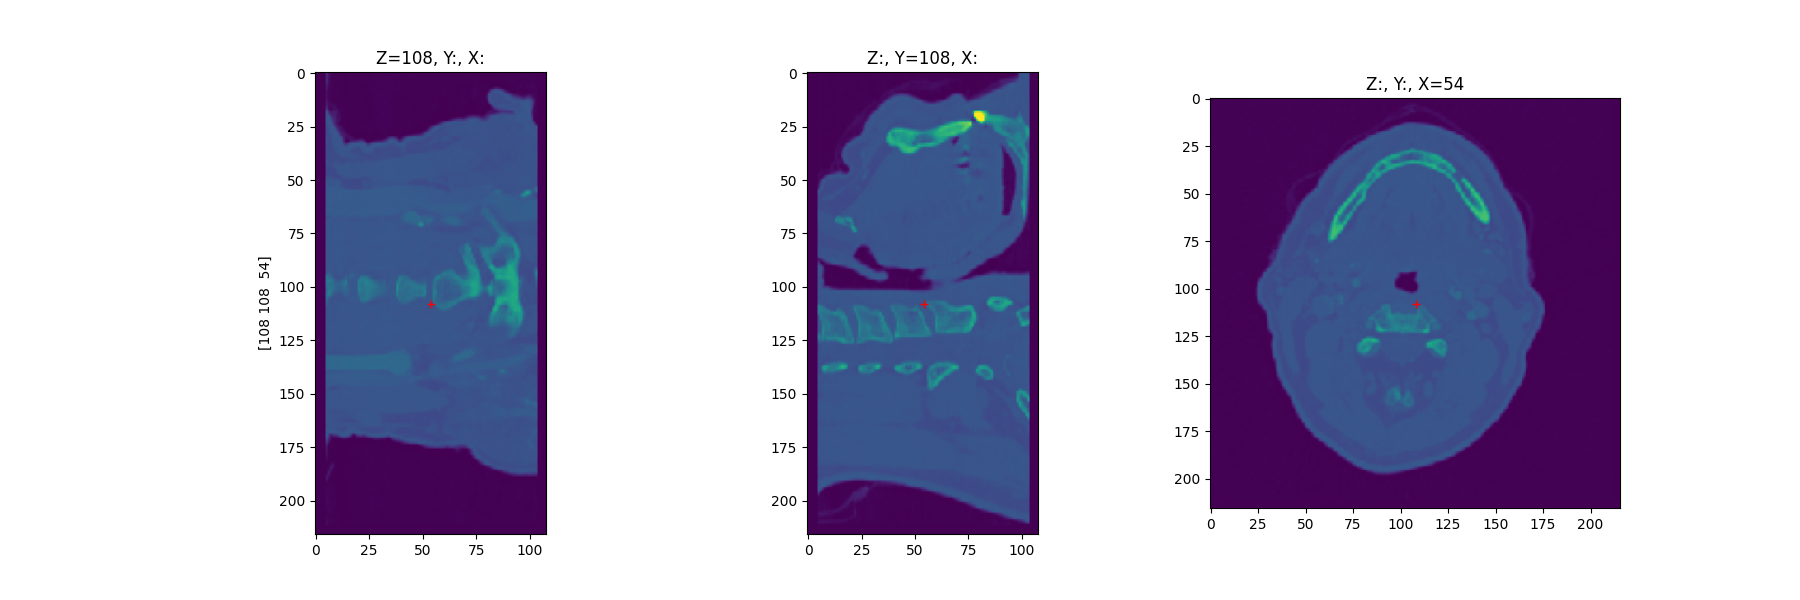

In [170]:
## VIS -> DCA
from numba import jit, njit

%matplotlib ipympl
plt.ion()

view_dsa_l = [
    # xh(ddsac_mca.astype(np.uint8)),
    dblock,
    # dsa, 
    # dsc,
    # array_op_merge,
]
# view_dsa_l = (dsb, 
#               (dsbs[1:-1, 1:-1, 1:-1]))
view_center_axes_names = "ZYX"
view_slice_axes = ((1, 2), (0, 2), (0, 1))  # common for v_dsa
# view_center_l = ([256, 256, 282], ) # (z, y, x)
view_center_l = [np.asarray(dsax.shape) //2 for dsax in view_dsa_l]

# view_center_l = ([2, 2, 2], ) # (z, y, x)
# view_dsa_l = (np.arange(256, dtype=np.uint8).reshape((4,8,8)), )

figsize = 6
vfig_res = (view_dsa_l.__len__(), view_slice_axes.__len__())
vfig, vax_l = plt.subplots(
    *vfig_res,
    figsize=[figsize*vfr for vfr in vfig_res[::-1]])
if vax_l.shape.__len__() == 1:
    vax_l = vax_l[None, ...]

vai_l = np.zeros(vax_l.shape, dtype=list)
for vdsa_ix, vdsa in enumerate(view_dsa_l):
    for vsx_ix, vsxx in enumerate(view_slice_axes):
        vaxx = vax_l[vdsa_ix][vsx_ix]
        blank_im = np.zeros(
            (vdsa.shape[vsxx[0]], vdsa.shape[vsxx[1]]),
            dtype = vdsa.dtype)
        blank_im[0, 0] = vdsa.max()
        axis_image = vaxx.imshow(blank_im)#, cmap='gray')
        axis_center = vaxx.plot([0], [0], marker='+', c='r')
        axis_title = vaxx.set_title("")
        axis_ylabel = vaxx.set_ylabel("")
        
        vai_l[vdsa_ix][vsx_ix] = [
            axis_image,
            axis_center[0],
            axis_title,
            axis_ylabel,
        ]

# @jit(nopython=False)
def update_dsa_view(vdsa_ix):
    vai = vai_l[vdsa_ix]
    vsx = view_slice_axes
    vce = view_center_l[vdsa_ix]
    vdsa = view_dsa_l[vdsa_ix]

    for axex, axes in enumerate(vsx):
        indices = tuple((vce[axix] if axix not in axes else slice(None)) 
            for axix in range(vce.__len__()))
        sliced = vdsa[indices] # if axes[0] < axes[1] else vdsa[indices].T
        # print(vax[axex].imshow(sliced))
        vai[axex][0].set_data(sliced)

        slice_center = ([vce[axes[1]]], [vce[axes[0]]])
        vai[axex][1].set_data(*slice_center)

        indices_str = ", ".join(tuple(f"{axix_name}={vce[axix]}" if axix not in axes else f"{axix_name}:" 
            for axix, axix_name in enumerate(view_center_axes_names)))
        vai[axex][2].set_text(indices_str)

    vai[0][3].set_text(str(vce))
    vfig.canvas.draw()
    # vfig.canvas.flush_events()
    # plt.gcf().canvas.draw()

def update_center(vdsa_ix, vax_ix, xy_center):
    view_center = view_center_l[vdsa_ix]
    slice_axes_updated = view_slice_axes[vax_ix]
    view_center[slice_axes_updated[0]] = xy_center[1]
    view_center[slice_axes_updated[1]] = xy_center[0]

def mouse_callback(event):
    on_canvas = event.inaxes is not None
    xy = (int(event.xdata), int(event.ydata)) if on_canvas else (None, None)
    vdsa_ix, vax_ix = np.argwhere(vax_l == event.inaxes)[0] if on_canvas else (None, None)
    button, dc = (int(event.button), event.dblclick)
    # print(event)
    # print(on_canvas, xy, (vdsa_ix, vax_ix), (button, dc))

    if on_canvas:
        if button == 1:
            update_center(vdsa_ix, vax_ix, xy)
            update_dsa_view(vdsa_ix)
        elif button == 3:
            for vdsa_ix in range(view_dsa_l.__len__()):
                update_center(vdsa_ix, vax_ix, xy)
                update_dsa_view(vdsa_ix)

for vdsa_ix in range(view_dsa_l.__len__()):
    update_dsa_view(vdsa_ix)

cid = vfig.canvas.mpl_connect('button_press_event', mouse_callback)

# vfig.canvas.draw()

In [ ]:
image = dsa[226, ...]
image = (255 /float(image.max())) *image
image = image.astype(np.uint8)

NameError: name 'dsa' is not defined

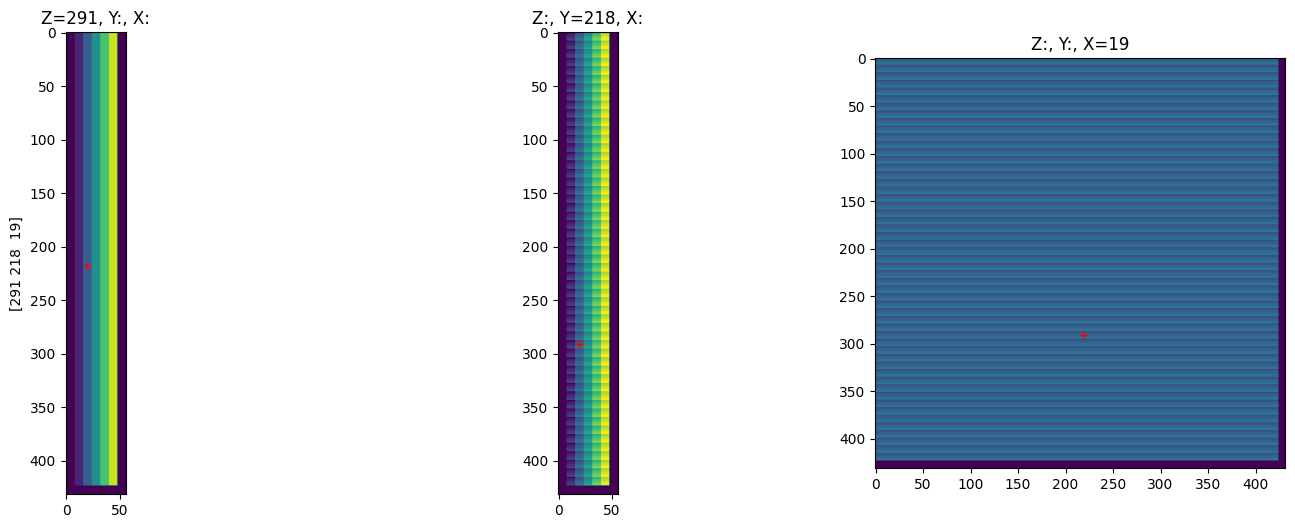

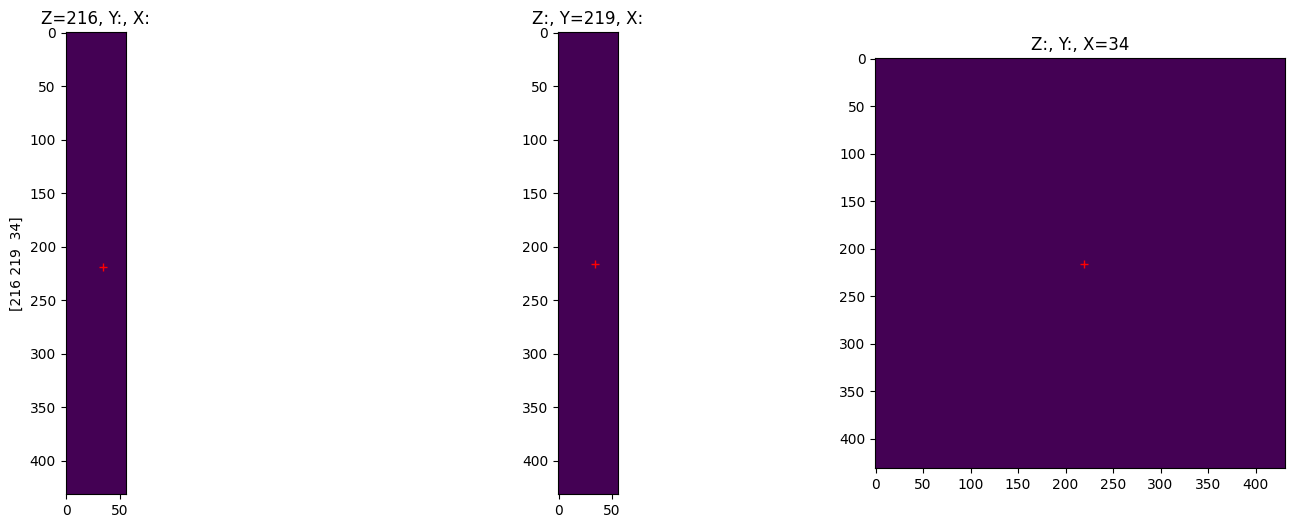

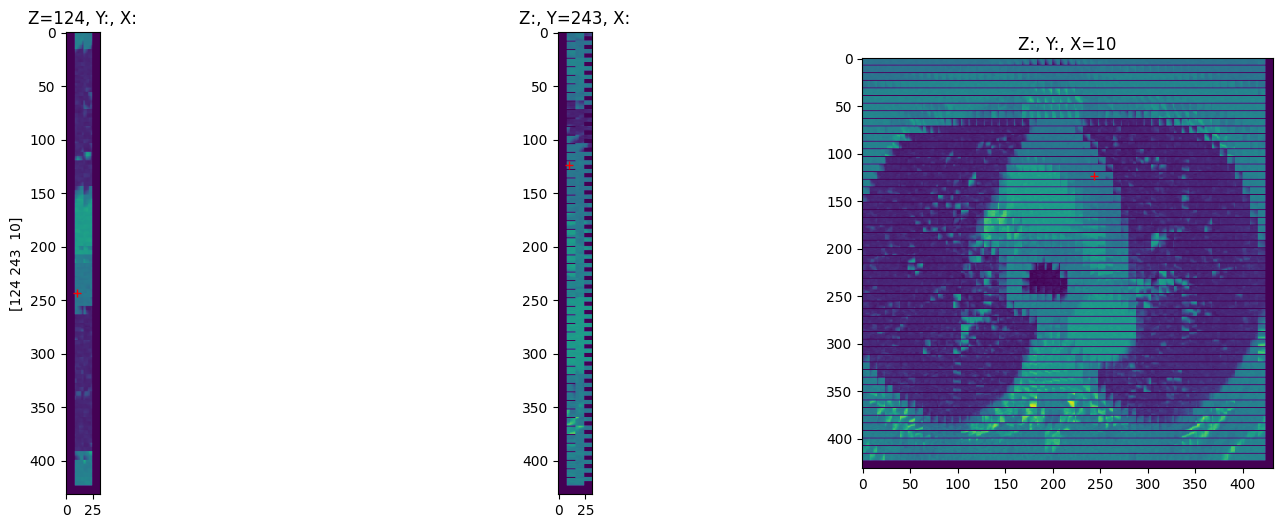

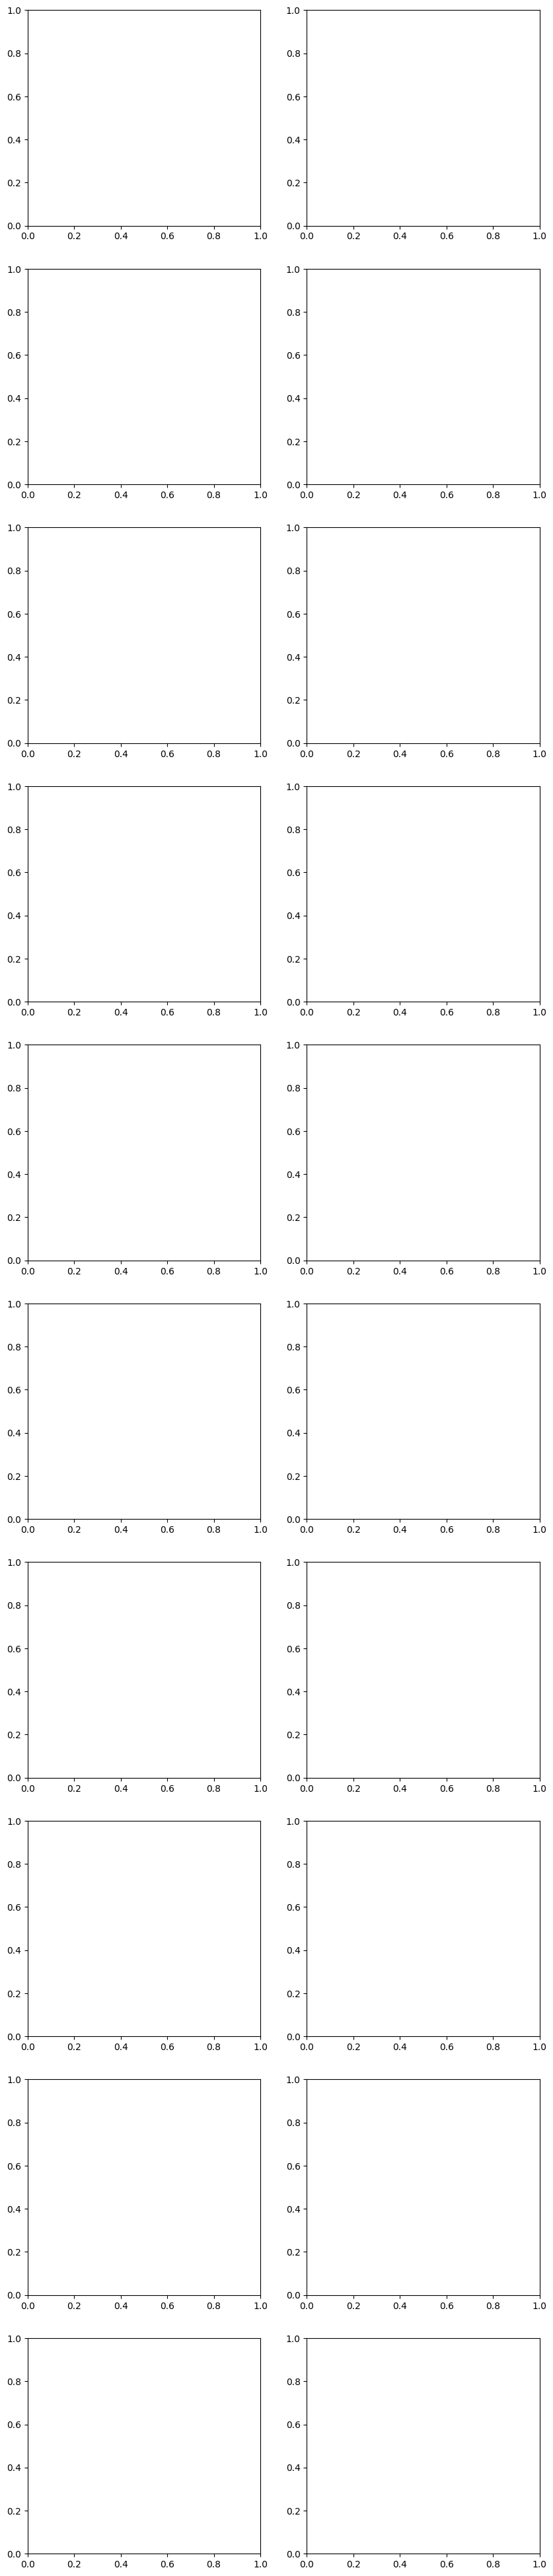

In [29]:
## TEST > SLICE > CANNY
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

slsh = 30
slic = list(slsh + sx for sx in range(0, 10))
fig, axs = plt.subplots(len(slic), 2, figsize=(10, 5*len(slic)))

for aix, iz in enumerate(slic):
    image = dsa[iz, ...]
    image = (iz /float(image.max())) *image
    image = image.astype(np.uint8)

    img = image
    edges = cv2.Canny(img,0,32)
    ax = axs[aix]
    ax[0].imshow(img,cmap = 'gray')
    ax[1].imshow(edges,cmap = 'gray')


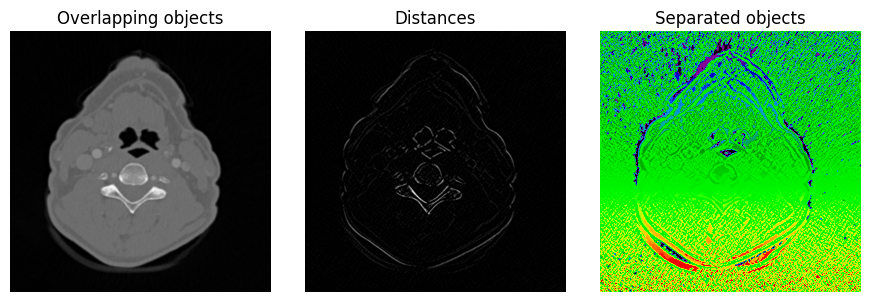

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

imgr = cv2.Sobel(image, 0, 1, 1)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = imgr #ndi.distance_transform_edt(image)
coords = peak_local_max(-distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

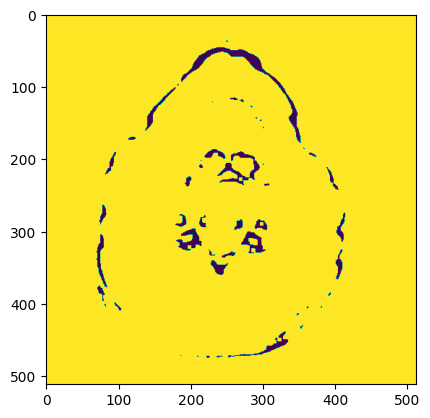

In [31]:


gray = array_op_merge[226, ...]

ret, bin_img = cv2.threshold(gray,
                             0, 255, 
                             cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img, 
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=2)

fig, ax = plt.subplots(1,1)
ax.imshow(bin_img)

In [9]:
import cv2
import numpy as np
from skimage.feature import peak_local_max
from skimage.segmentation  import watershed
from scipy import ndimage


gray = image
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

distance_map = ndimage.distance_transform_edt(thresh)
local_max = peak_local_max(distance_map, indices=False, min_distance=20, labels=thresh)

# Perform connected component analysis then apply Watershed
markers = ndimage.label(local_max, structure=np.ones((3, 3)))[0]
labels = watershed(-distance_map, markers, mask=thresh)

# Iterate through unique labels
total_area = 0
for label in np.unique(labels):
    if label == 0:
        continue

    # Create a mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255

    # Find contours and determine contour area
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv2.contourArea)
    area = cv2.contourArea(c)
    total_area += area
    cv2.drawContours(image, [c], -1, (36,255,12), 4)

print(total_area)
cv2.imshow('image', image)
cv2.waitKey()

C:\Users\krism\AppData\Local\Temp\ipykernel_22736\2399666555.py:14: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(distance_map, indices=False, min_distance=20, labels=thresh)


28797.0


In [10]:
## TEST > LINEAR KERNEL > OPTIMIZE
import cupy as cp
da                  = cp.asarray
ha                  = cp.asnumpy

dsa                 = np.asarray([ds.pixel_array for ds in ds_l])
dsa                 = np.flip(dsa, 0)  # unmussolinize image

patch_shape         = (64,) *3
ndim = patch_shape.__len__()
# dsa                 = dsa[tuple(slice(psx) for psx in patch_shape)]  # test

kernel              = sobel_kernel3s[0]
kernel_shape        = kernel.shape
ndim                = kernel.shape.__len__()
kernel_center       = tuple(((ksx-1)//2)  for ksx in kernel_shape)
pad_shape_in        = (
    tuple(kcx           for _,   kcx    in zip(kernel_shape, kernel_center)), 
    tuple((ksx-1)-kcx   for ksx, kcx    in zip(kernel_shape, kernel_center)))
pad_shape_op        = (
    tuple(0             for _           in zip(kernel_shape, kernel_center)), 
    tuple(0             for _           in zip(kernel_shape, kernel_center)))

array_shape_in      = (64,) *ndim                                               # padded
array_shape_op      = tuple(asi -(psil+psiu) +(psol+psou)                      
    for asi, psil, psiu, psol, psou 
    in zip(array_shape_in, *pad_shape_in, *pad_shape_op))                       # unpadded preferably (no reason for op padding?)

pad_in_shl           = na(pad_shape_in[0])
pad_op_shl           = na(pad_shape_op[0])
pad_io_shl          = pad_in_shl - pad_op_shl

dspain, pgrid_shape, amerge_shape   \
                    = pad_patchify(dsa, patch_shape, pad_shape_in, ((0,) *3,) *2, (0,) *3, tv="patchify")

patch_op_shape      = tuple(array_shape_op)
dspaop              = np.zeros(pgrid_shape + patch_op_shape, dtype=dspain.dtype)


kernel_ixo          = np.ogrid[tuple(slice(ksx) for ksx in kernel_shape     )]
arr_op_ixo          = np.ogrid[tuple(slice(asx) for asx in array_shape_op   )]
arr_in_ixo          = tuple(arr_op_ixox + pad_io_shlx for arr_op_ixox, pad_io_shlx in zip(arr_op_ixo, pad_io_shl))

kernel_d                =       da(kernel)
kernel_ixof_d           = tuple(da(kernel_ixox.squeeze())   for kernel_ixox      in kernel_ixo   )
arr_op_ixo_d            = tuple(da(arr_op_ixox)             for arr_op_ixox      in arr_op_ixo   )

for pgrid_ix            in tqdm(np.ndindex(pgrid_shape), total=np.prod(pgrid_shape), desc="ogrid lk"): ##MEMx: 1*IN + 1*CALC + 1*OUT + rootN*c*INDEX
    patch_in_d          = da(dspain[pgrid_ix])
    patch_op_d          = cp.zeros(patch_op_shape)
    for kernel_ixt      in cp.ndindex(kernel_shape):
        patch_in_kix    = tuple(arr_op_ixox + kernel_ixofx[kernel_ixtx] 
                            for     arr_op_ixox,    kernel_ixofx,   kernel_ixtx 
                            in  zip(arr_op_ixo_d,   kernel_ixof_d,  kernel_ixt ))
        patch_op_d      += patch_in_d[patch_in_kix] * kernel_d[kernel_ixt]
    dspaop[pgrid_ix]    = ha(patch_op_d)

kernel_ixaa         = np.mgrid[tuple(slice(0, ksx)  for ksx     in kernel_shape)]                               ##(iAxis<indexing>, kZ,  kY,  kX);  ixaa = index array axial absolute
kernel_ixac         = kernel_ixaa - pad_in_shl[(slice(None),)   + (None,) *ndim]
arr_op_ixaa         = np.mgrid[tuple(slice(0, psx)  for psx     in array_shape_op)]
arr_io_ixaa         = arr_op_ixaa + pad_in_shl[(slice(None),)   + (None,) *ndim]

kernel_d                = da(kernel)
kernel_ixaa_d           = da(kernel_ixaa)
arr_op_ixaa_d           = da(arr_op_ixaa)

for pgrid_ix            in tqdm(np.ndindex(pgrid_shape), total=np.prod(pgrid_shape), desc="mgrid lk"): ##MEMx: 1*IN + 1*CALC + 1*OUT + 1*INDEX
    patch_in_d          = da(dspain[pgrid_ix])
    patch_op_d          = cp.zeros(patch_op_shape)
    for kernel_ixt      in cp.ndindex(kernel_shape): 
        # patch_in_kix    = arr_op_ixaa_d + kernel_ixaa_d[(slice(None),) + kernel_ixt].reshape((ndim,) + (1,) *ndim)
        # patch_in_kix    = arr_op_ixaa_d + kernel_ixaa_d[(slice(None),) + kernel_ixt][(slice(None),) + (None,) *3]
        patch_in_kix    = arr_op_ixaa_d + da(kernel_ixt)[(slice(None),) + (None,) *ndim]
        patch_op_d      += patch_in_d[tuple(patch_in_kix)] * kernel_d[kernel_ixt]
    dspaop[pgrid_ix]    = ha(patch_op_d)

for pgrid_ix            in tqdm(np.ndindex(pgrid_shape), total=np.prod(pgrid_shape), desc="slice lk"): ##MEMx: 1*IN + 1*CALC + 1*OUT
    patch_in_d          = da(dspain[pgrid_ix])
    patch_op_d          = cp.zeros(patch_op_shape)
    for kernel_ixt      in cp.ndindex(kernel_shape): 
        patch_in_kix    = tuple(slice(kix, asx + kix) for kix, asx in zip(kernel_ixt, array_shape_op))
        patch_op_d      += patch_in_d[patch_in_kix] * kernel_d[kernel_ixt]
    dspaop[pgrid_ix]    = ha(patch_op_d)

# > DUMP
e = tuple(  
        arr_op_ixox[(slice(None),)  *ndim   + (None,)           *ndim] 
    +   kernel_ixox[(None,)         *ndim   + (slice(None),)    *ndim] 
    for arr_op_ixox, kernel_ixox in zip(arr_op_ixo, kernel_ixo))
[print(i.shape) for i in e]

kernel_ixaf         = kernel_ixaa.reshape((ndim, -1))                           ##(iAxis<indexing>, kZ  *kY  *kX);  ixaf = index array flat  adjusted
arraop_ixaa          = np.mgrid[tuple(slice(0, psx) 
                        for psx in array_shape_op)]                             ##(iAxis<indexing>, aoZ, aoY, aoX)
arraop_ixaf          = arraop_ixaa.reshape((ndim, -1))                            ##(iAxis<indexing>, aoZ *aoY *aoX)
arrain_ixaf          = arraop_ixaf + (pad_in_shl - pad_op_shl)[:, None]
# mapping_ak_ixaf     = arrop_ixaf[:, :, None] + kernel_ixaf[:, None, :]          ##(iAxis<indexing>, aoZ *aoY *aoX, kZ *kY *kX); for reduction over kA axis; too much vram loss?
kernel_flat         = kernel[tuple(kernel_ixaf)]


# # patch_pad = np.zeros(patch_shape + (pad_shape *2), dtype=dtype)  # ((pZ, pY, pX) +Padding)
# # patch_pad[tuple(slice(pad_sx, pad_sx+patch_sx) for pad_sx, patch_sx in zip(pad_shape, patch_shape))] = patch

# dsbs = (patch_pad[tuple(pkix_flat)] * kernel_flat).sum(axis=-1).reshape(patch_shape)


slice lk: 100%|██████████| 810/810 [00:04<00:00, 170.30it/s]

(62, 1, 1, 3, 1, 1)
(1, 62, 1, 1, 3, 1)
(1, 1, 62, 1, 1, 3)


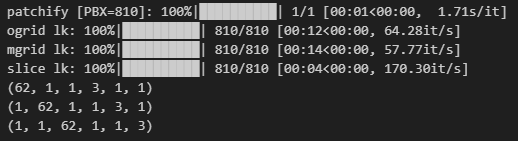

In [205]:
## DRAFT

import cupy as cp
da = cp.asarray
ha = cp.asnumpy

dsa = np.asarray([ds.pixel_array for ds in ds_l])
dsa = np.flip(dsa, 0)  # unmussolinize image

patch_shape = (64,) *3
dsa = dsa[tuple(slice(psx) for psx in patch_shape)]  # test

dspain, pgrid_shape, amerge_shape = pad_patchify(dsa, patch_shape, pad_shape_in, ((0,) *3,) *2, (0,) *3, "patchify")
dspaop = np.zeros(pgrid_shape + tuple(array_shape_op), dtype=dspain.dtype)

kernel_flat_d = da(kernel_flat)
kernel_ixaf_d   = da(kernel_ixaf)
arrain_ixaf_d    = da(arrain_ixaf)

for pgrid_ix in tqdm(np.ndindex(pgrid_shape), total=np.prod(pgrid_shape)):
    patch_in_d = da(dspain[pgrid_ix])

    
    

100%|██████████| 8/8 [00:00<00:00, 2663.90it/s]


In [339]:
# DRAFT
# b = np.ogrid[0:3, slice(0,3)]

# e = np.ndindex(2,2,3)
# e1 = list(e)
# e2 = list(e)
# print(e1, e2)

# o = "eee"
# for i in tqdm(e, desc=o, disable=not o):
#     # print(i)
#     pass

# dsap[0,0,0]
# print(kernel_flat_d)
# kernel_ixaf_d
# np.ogrid[0:3, slice(0,3)]
# tuple(cp.mgrid[0:3, 0:3])[0].device
# np.prod(pgrid_shape)
# tuple(m+g for  m, g in  zip(np.ogrid[0:4, 0:4, 0:4], [1,2,3]))
# arrain_ixaf.shape

# a = np.arange(64).reshape((4,4,4))
# b = np.arange(16).reshape((4,4))
# np.ogrid[0:4, 0:4, 0:4]
# print(b)
# a[ [[[0, 1]], [[1, 2]]], [[[0], [1]]], [[[0, 1]]] ]
# b[ [[0, 1, 2, 1],
#     [1, 2, 3, 1]], [[1, 2, 1, 0], [1, 2, 1, 0]] ]
# b[ [[0, 1], [1, 2]], [[0, 1], [0, 1]] ]
# b[ [[0, 0, 0, 0],
#     [1, 1, 1, 1],
#     [2, 2, 2, 2],
#     [3, 3, 3, 3]], 
#    [[0, 1, 2, 3],
#     [0, 1, 2, 3],
#     [0, 1, 2, 3],
#     [0, 1, 2, 3]] ]
# b[ [[[0, 1]],
#     [[1, 2]],
#     [[2, 3]],
#     [[3, 0]]],
#    [[[0, 1], [1, 2], [2, 3], [3, 0]]]]
# b[ [[[[0], [1]]],
#     [[[1], [2]]],
#     [[[2], [3]]],
#     [[[3], [0]]]],
#    [[[[0, 1]], [[1, 2]], [[2, 3]], [[3, 0]]]]
# ].shape
# cp.arange(64).reshape((4,4,4))[b]
# cp.asarray((1,2,3))
# dsa.dtype
# na([[[[1,2,3]]]]).squeeze()
# np.mgrid[0:2, 0:2, 0:2] + na((1, 2, 3))[(slice(None),) + (None,) *3]

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


array([[[[1, 1],
         [1, 1]],

        [[2, 2],
         [2, 2]]],


       [[[2, 2],
         [3, 3]],

        [[2, 2],
         [3, 3]]],


       [[[3, 4],
         [3, 4]],

        [[3, 4],
         [3, 4]]]])

In [14]:


ps = 64
dsb = dsa[tuple(slice(sp, sp+ps) for sp in (170, 230, 140))]
print(dsa.shape)
print(dsb.shape)

(563, 512, 512)
(64, 64, 64)


In [7]:
patch = tt

# patch_pad = np.zeros(patch_shape + (pad_shape *2), dtype=dtype)  # ((pZ, pY, pX) +Padding)
# patch_pad[tuple(slice(pad_sx, pad_sx+patch_sx) for pad_sx, patch_sx in zip(pad_shape, patch_shape))] = patch

dsbs = (patch_pad[tuple(pkix_flat)] * kernel_flat).sum(axis=-1).reshape(patch_shape)


In [8]:
# np.mgrid[tuple(slice(0, tv_shx) for tv_shx in tv.shape)+(slice(0, 1),)].shape
# tuple(slice(pad_sx, pad_sx+patch_sx) for pad_sx, patch_sx in zip(pad_shape, patch_shape)) #patch_pad.shape
# patch_pad[65, :, :].sum()
# dsbs[3, :, :].sum()

In [9]:
# tuple(print(0, tv_shx) for tv_shx in tv.shape)
# i.reshape((3, -1))
# (Ellipsis, Ellipsis)
for i in range(3):
    print(tuple((pkix_flat[i, 0])))
print(patch_pad[tuple((pkix_flat)[:, -1])])
print(kernel_flat)
print(patch_pad[tuple((pkix_flat)[:, -1])] * kernel_flat)

(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2)
(0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2)
(0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2)
[1003 1012    0 1012 1018    0    0    0    0 1012 1009    0 1024 1023
    0    0    0    0    0    0    0    0    0    0    0    0    0]
[[ 1  2  1  2  4  2  1  2  1  0  0  0  0  0  0  0  0  0 -1 -2 -1 -2 -4 -2
  -1 -2 -1]]
[[1003 2024    0 2024 4072    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [10]:
# a = np.mgrid[0:4, 0:4, 0:4]
# tv[tuple(a)]
# a + na([1,2,3])[..., None, None, None]
# (t:=4) and t+3
# slice(t2:=4, t2+5)
# tuple((krax:=(ksax-1)//2) and slice(-krax, (-krax+ksax+1)) for ksax in kernel.shape)
# tt

In [11]:
# i = kernel_indices+1
# indices_kernel3.shape # (3, 3, 3, 3)
# tv[..., i[..., None]]#.shape # (4, 4, 3, 3, 3)
# tv[..., indices_kernel3[0]][1, 1, 1]
# tv[tuple(i[0, 0])]
# tt[0]
# i.shape

# tt[0][[[0, 0], [1, 1]], [[0, 1], [0, 1]]]
# kernel_indices+1
# tt[[slice(1,2), slice(2,3)]]
# (tt[tuple(kernel_indices.reshape((ndim, -1))+1)] )#* kernel_flat).sum(axis=-1)
# patch_indices.shape, kernix_flat.shape


In [309]:
# patchify.patchify(np.arange(125).reshape((5,5,5,)), (2, 2, 2), 2).shape#[-1,-1,-1]

# e = plt.imshow(np.ones((5, 5)))
# e.set_array(np.ones((5, 5))*2)
# dir(e)
# # # f, a=plt.subplots(2, 2)
# # # a[0,0].set_array(np.ones((5, 5))*2)
# # e
# # dsa.dtype
# # print(vai_l[0][0].get_array())
# dir(vai_l[0][0])
# dir(vax_l[0][0])
# vdsa.max()

4095

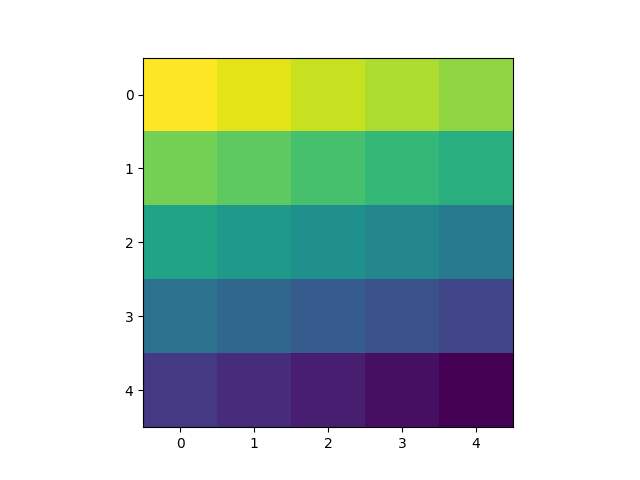

In [310]:
# %matplotlib ipympl
# import numpy as np
# import matplotlib.pyplot as plt

# plt.ion()

# fig, ax = plt.subplots(1, 1)
# ai = ax.imshow(np.arange(25, dtype=np.uint8)[::-1].reshape((5,5,)))

# k = np.arange(25, dtype=np.uint8).reshape((5,5,))

# def o(event): 
#     ai.set_data(k)
#     print("dupa", ai.get_array())
#     ax.autoscale_view()  
#     ax.relim()
#     ax.autoscale_view(True,True,True)
#     fig.canvas.draw()
#     fig.canvas.flush_events()

# cid = fig.canvas.mpl_connect('button_press_event', o)


# def pad_unpatchify(
#         patch_array: np.ndarray,
#         padded_patch_shape,
#         pad_shape,
#         array_shape,
# ):
#     na = np.asarray
#     ndim                = padded_patch_shape.__len__()

#     pdp_sh              = na(padded_patch_shape)
#     pad_shl,  pad_shr   = na(pad_shape)
#     upd_sh              = pdp_sh - (pad_shl+pad_shr)
#     patch_step          = upd_sh

#     pad_shu             = pdp_sh - pad_shr
#     pgrid_sh            = patch_array.shape[-(ndim*2):-ndim]

#     ## find indices for iteration
#     patch_mgrid         = np.mgrid[(slice(psx) for psx in upd_sh)]
#     pgrid_mgrid         = np.mgrid[(slice(psx) for psx in pgrid_sh)]

#     ## unpatchify
#     unpad_crop = tuple(slice(None) for _ in pad_shl) + tuple(slice(cl, cu) for cl, cu in zip(pad_shl, pad_shu))
#     unpad_patch_array = patch_array[unpad_crop]

#     ## merge
#     output_array_ex_sh = pgrid_sh * upd_sh
#     output_array_ex     = np.zeros(output_array_ex_sh, dtype=patch_array.dtype)

#     for pgrid_ix in pgrid_mgrid.reshape((ndim, -1)).T:
#         patch_shift = (pgrid_ix * patch_step).reshape((ndim,) + (1,) *ndim)
#         output_array_ex[tuple(patch_mgrid + patch_shift)] = unpad_patch_array[tuple(pgrid_ix)]

#     ## discard excess
#     output_array_sh     = array_shape
#     output_array        = output_array_ex[tuple(slice(osx) for osx in output_array_sh)]

#     return output_array




In [ ]:
## DRAFT > SOBEL GRAD
# import cupy as cp
cp = np
na = cp.asarray

ndim = 3  # #of dimensions

# tt_sbase = 4  # tensor shape base
# tt_shape = (tt_sbase,)*ndim
# tt = cp.arange(tt_sbase**ndim).reshape(tt_shape)  # test tensor
tt = dsb

# patch_shape = (4, 4, 4)
dtype =  tt.dtype
patch_shape = na(tt.shape)
kernel_shape = na((3,)*ndim)
pad_shape = (kernel_shape-1)//2

sobel_kernel3_gen = cp.asarray([
    [[+1, +2, +1], [+2, +4, +2], [+1, +2, +1]],
    [[ 0,  0,  0], [ 0,  0,  0], [ 0,  0,  0]],
    [[-1, -2, -1], [-2, -4, -2], [-1, -2, -1]],
])
sobel_kernel3s = (
    sobel_kernel3_gen,
    sobel_kernel3_gen.swapaxes(0, 1),
    sobel_kernel3_gen.swapaxes(0, 2),
)  # (iAxis<kernel>, kZ, kY, kX)
sharpen_kernel3 = cp.asarray([
    [[0,0,0], [0,-1,0], [0,0,0]],
    [[0,-1,0], [-1,7,-1], [0,-1,0]],
    [[0,0,0], [0,-1,0], [0,0,0]],
])

# kernel = sharpen_kernel3
kernel = sobel_kernel3s[0]
kernel_flat = kernel.reshape((-1,))[None]  # (iZ*iY*iX=1, kZ*kY*kX)

# kernel_indices = cp.mgrid[tuple(slice(-pad_sx, -pad_sx+kernel_sx) for pad_sx, kernel_sx in zip(pad_shape, kernel_shape))]  # (iAxis<index>, kZ, kY, kX)
kernel_indices = cp.mgrid[tuple(slice(0, kernel_sx) for _, kernel_sx in zip(pad_shape, kernel_shape))]  # (iAxis<index>, kZ, kY, kX)
kernix_flat = kernel_indices.reshape((ndim, -1))  # (iAxis<indexing>, kZ*kY*kX)

patch_indices = cp.mgrid[tuple(slice(0, patch_sx) for patch_sx in patch_shape)] # (iAxis<index>, pZ, pY, pX)
patchix_flat = patch_indices.reshape((ndim, -1))  # (iAxis<indexing>, pZ*pY*pX)
pkix_flat = patchix_flat[:, :, None] + kernix_flat[:, None, :]  # (iAxis<indexing>, pZ*pY*pX, kZ*kY*kX)


patch = tt

# patch_pad = np.zeros(patch_shape + (pad_shape *2), dtype=dtype)  # ((pZ, pY, pX) +Padding)
# patch_pad[tuple(slice(pad_sx, pad_sx+patch_sx) for pad_sx, patch_sx in zip(pad_shape, patch_shape))] = patch

dsbs = (patch_pad[tuple(pkix_flat)] * kernel_flat).sum(axis=-1).reshape(patch_shape)

In [ ]:
## TEST > PATCHIFY

def pad_patchify(
        input_array: np.ndarray,
        padded_patch_shape,                                     ##(   ndim)
        pad_shape,                                              ##(2, ndim)
        input_crop_shape,                                       ##(2, ndim)
        patch_excess_min,                                       ##(   ndim)
        tqdmv = None
):
    na = np.asarray
    ndim = padded_patch_shape.__len__()

    ## calc actual lower padding (not being covered by crop margin)
    pad_shl,  pad_shr   = na(pad_shape)                         # shl, shu, shr = shape [span] lower, upper, rearwards
    crop_shl, crop_shr  = na(input_crop_shape)        
    arr2opa_shl         = crop_shl - pad_shl                    # position of opa's i0 relative to array (consider it vec); opa = outer-padded array
    opa2arr_shl         = pad_shl - crop_shl                    # postition of array's i0 relative to opa
    arr_crop_shl        = np.maximum(0, arr2opa_shl)            # reduce input cropping if no enough crop to satisfy padding
    opa_pad_shl         = np.maximum(0, opa2arr_shl)            # pad needing artificial fulfilling as not being covered by cropped image

    ## calc how much patches will be there  
    array_sh            = na(input_array.shape) 
    roi_sh              = array_sh - (crop_shl + crop_shr)      # roi = region of interst (after cropping)
    pdp_sh              = na(padded_patch_shape)                # pdp = padded_patch
    upd_sh              = pdp_sh - (pad_shl+pad_shr)            # upd = unpadded[_patch]
    patch_step          = upd_sh                                # step between 0th elements of consecutive patches
    upd_ex_min_sh       = na(patch_excess_min)
    pgrid_sh, pex_rm_sh = np.divmod(roi_sh, patch_step)
    pex_accept          = pex_rm_sh >= upd_ex_min_sh
    pgrid_sh            = pgrid_sh.astype(roi_sh.dtype) + pex_accept

    ## calc opa upper padding
    opa_sh              = (pgrid_sh * upd_sh) + (pad_shl + pad_shr)
    arr2opa_shu         = arr2opa_shl + opa_sh                  # position of opa's ie relative to array
    opa2arr_shu         = opa2arr_shl + array_sh
    arr_crop_shu        = np.minimum(array_sh, arr2opa_shu)
    opa_pad_shu         = np.minimum(opa_sh,   opa2arr_shu)
    opa_pad_shr         = opa_sh - opa_pad_shu

    ## quick checks
    assert np.all(upd_sh > 0)
    assert np.all(upd_ex_min_sh <= upd_sh)
    assert np.all(pgrid_sh > 0)

    ## pad opa
    input_crop          = tuple(slice(cl, cu) for cl, cu in zip(arr_crop_shl, arr_crop_shu))
    input_pad_T         = na((opa_pad_shl, opa_pad_shr)).T
    opa                 = np.pad(input_array[input_crop], input_pad_T, mode='edge')

    ## find indices for iteration
    # patch_indices = np.mgrid[(slice(psx) for psx in pdp_sh)]
    # pgrid_indices = np.mgrid[(slice(psx) for psx in pgrid_sh)]
    # patch_mgrid         = np.mgrid[(slice(psx) for psx in pdp_sh)]
    # patch_ixo           = tuple(patch_ixox for patch_ixox in np.ogrid[(slice(psx) for psx in pdp_sh)])
    pgrid_shape         = tuple(pgrid_sh)

    ## patchify
    patch_array = np.zeros(np.concatenate((pgrid_sh, pdp_sh)), dtype=input_array.dtype)
    for pgrid_ix in tqdm(np.ndindex(pgrid_shape), total=pgrid_sh.prod(), desc=tqdmv, disable=not tqdmv):
        ## MGRID OPT 14s
        # patch_shift = (na(pgrid_ix) * patch_step).reshape((ndim,) + (1,) *ndim)
        # patch_array[pgrid_ix] = opa[tuple(patch_mgrid + patch_shift)]

        ## OGRID OPT 11s
        # patch_ogrid     = tuple(    patch_ixox + (  psx * pgrid_ixx)
        #                     for     patch_ixox,     psx,  pgrid_ixx 
        #                     in  zip(patch_ixo,      patch_step,   pgrid_ix ))
        # patch_array[pgrid_ix] = opa[patch_ogrid]

        ## SLICE OPT 4s
        patch_crop = tuple(slice(usx*pgx, (usx*pgx)+psx) for usx, psx, pgx in zip(upd_sh, pdp_sh, pgrid_ix))
        patch_array[pgrid_ix] = opa[patch_crop]


    ## save info about actual shape
    pex_crop_shr        = (upd_sh - pex_rm_sh) * pex_accept
    array_shape         = (pgrid_sh * upd_sh) - pex_crop_shr

    return patch_array, pgrid_shape, array_shape
    # return patch_array, list(np.ndindex(pgrid_shape)), array_shape


def pad_unpatchify(
        patch_array: np.ndarray,
        padded_patch_shape,
        pad_shape,
        array_shape,
        tqdmv = None
):
    na = np.asarray
    ndim                = padded_patch_shape.__len__()

    pdp_sh              = na(padded_patch_shape)
    pad_shl,  pad_shr   = na(pad_shape)
    upd_sh              = pdp_sh - (pad_shl+pad_shr)
    patch_step          = upd_sh

    pad_shu             = pdp_sh - pad_shr
    pgrid_shape         = patch_array.shape[-(ndim*2):-ndim]
    pgrid_sh            = na(pgrid_shape)

    ## unpatchify
    unpad_crop = tuple(slice(cl, cu) for cl, cu in zip(pad_shl, pad_shu))
    
    # unpad_patch_array   = patch_array[(...,) + unpad_crop]
    # patch_mgrid         = np.mgrid[(slice(psx) for psx in upd_sh)]
    # pgrid_mgrid         = np.mgrid[(slice(psx) for psx in pgrid_sh)]

    ## merge
    output_array_ex_sh = pgrid_sh * upd_sh
    output_array_ex     = np.zeros(output_array_ex_sh, dtype=patch_array.dtype)

    for pgrid_ix in tqdm(np.ndindex(pgrid_shape), total=pgrid_sh.prod(), desc=tqdmv, disable=not tqdmv):
        ## MGRID OPT 11s
        # patch_shift = (na(pgrid_ix) * patch_step).reshape((ndim,) + (1,) *ndim)
        # output_array_ex[tuple(patch_mgrid + patch_shift)] = unpad_patch_array[tuple(pgrid_ix)]

        ## SLICE OPT 4s
        patch_crop = tuple(slice(usx*pgx, (usx*pgx)+usx) for usx, pgx in zip(upd_sh, pgrid_ix))
        output_array_ex[patch_crop] = patch_array[pgrid_ix + unpad_crop]

    ## discard excess
    output_array_sh     = array_shape
    output_array        = output_array_ex[tuple(slice(osx) for osx in output_array_sh)]

    return output_array


In [ ]:
## TEST > KERNEL APPLY
import cupy as cp
xp = cp
na                  = np.asarray 
da                  = cp.asarray if xp==cp else np.asarray
ha                  = cp.asnumpy if xp==cp else np.asarray

dsa                 = na([ds.pixel_array for ds in ds_l])
dsa                 = np.flip(dsa, 0)  # unmussolinize image
# dsa                 = dsa[tuple(slice(psx) for psx in patch_shape)]  # test
proc_dtype          = dsa.dtype

pdim                = 3
patch_shape         = (128,) *pdim
patch_pad_shape     = ((1,) *pdim,) *2


kernel              = sobel_kernel3s[0].astype(proc_dtype)
kernel_center       = (1,) *pdim

kernel_shape        = kernel.shape
kdim                = kernel.shape.__len__()
pad_in_shape        = patch_pad_shape
pad_io_shape        = (
    tuple(kcx           for _,   kcx    in zip(kernel_shape, kernel_center)), 
    tuple((ksx-1)-kcx   for ksx, kcx    in zip(kernel_shape, kernel_center)))
pad_op_shape        = tuple(tuple(pishsx - pioshsx 
                        for pishsx, pioshsx in zip(pishs,  pioshs))
                        for pishs,  pioshs  in zip(pad_in_shape, pad_io_shape))
kernel_adjust       = pad_op_shape[0]
# print(pad_op_shape)
assert np.all(na(pad_op_shape) >= 0)                                             # enough padding for kernel

patch_in_shape      = patch_shape                                               # padded
patch_op_shape      = tuple(patch_shx - (pad_shxl + pad_shul)                      
    for patch_shx, pad_shxl, pad_shul 
    in zip(patch_in_shape, *pad_io_shape))                                      # unpadded preferably


dspain, pgrid_shape, amerge_shape   \
                    = pad_patchify(dsa, patch_shape, patch_pad_shape, ((0,) *3,) *2, (0,) *3, tv="patchify")


dspaop              = np.zeros(pgrid_shape + patch_op_shape, dtype=np.int16)  # dtype=dspain.dtype) # % todo: parametrize when input data signed
kernel_d                = da(kernel)


for pgrid_ix            in tqdm(np.ndindex(pgrid_shape), total=np.prod(pgrid_shape), desc="linear kernel apply"): # type: ignore ##MEMx: 1*IN + 1*CALC + 1*OUT
    patch_in_d          = da(dspain[pgrid_ix])
    patch_op_d          = xp.zeros(patch_op_shape)
    for kernel_ixt      in xp.ndindex(kernel_shape): 
        patch_in_kix    = tuple(slice(kix + kadjx, asx + kix + kadjx) for kix, asx, kadjx in zip(kernel_ixt, patch_op_shape, kernel_adjust))
        patch_op_d      += patch_in_d[patch_in_kix] * kernel_d[kernel_ixt]
    dspaop[pgrid_ix]    = ha(patch_op_d)


for bl, bix             in batchify(np.ndindex(pgrid_shape), patch_shape, 
                            2**36 /proc_dtype.itemsize, (0, *((0,)*(pdim-1)), 3), 
                            tv="linear kernel batchified seqencing"):
    patch_in_d          = da(dspain[bix])
    patch_op_d          = xp.zeros(bl + patch_op_shape, dtype=patch_in_d.dtype)
    for kernel_ixt      in xp.ndindex(kernel_shape): 
        patch_in_kix    = tuple(slice(kix + kadjx, asx + kix + kadjx) for kix, asx, kadjx in zip(kernel_ixt, patch_op_shape, kernel_adjust))
        patch_op_d      += patch_in_d[(slice(None),) + patch_in_kix] * kernel_d[kernel_ixt]
    dspaop[bix]         = ha(patch_op_d)
del patch_in_d, patch_op_d


# pb_all                  = (slice(None),)
# kernel_ixon             = tuple(kixox[(None,) *pdim + (slice(None),) *pdim] for kixox in xp.ogrid[tuple(slice(kshx) for kshx in kernel_shape)])
# patch_ixo               = tuple(xp.ogrid[tuple(slice(kadjx, pshx + kadjx) for pshx, kadjx in zip(patch_op_shape, kernel_adjust))])
# pa2kr_ixo               = tuple(pixox[(slice(None),) *pdim + (None,) *pdim] + kixox for pixox, kixox in zip(patch_ixo, kernel_ixon))
# for bl, bix             in batchify(np.ndindex(pgrid_shape), patch_shape, 
#                             2**33 /proc_dtype.itemsize, (0, *((0,)*(pdim-1)), (2 + np.prod(kernel_shape))*2), 
#                             tv="linear kernel batchified reducing"):
#     patch_in_d          = da(dspain[bix])
#     patch_op_d          = patch_in_d[pb_all + pa2kr_ixo] * kernel_d[kernel_ixon]
#     dspaop[bix]         = ha(patch_op_d[..., None].sum(axis=(-4, -3, -2)).squeeze())


dspaop              = np.abs(dspaop).astype(dspain.dtype)
array_op_merge = pad_unpatchify(dspaop, patch_op_shape, pad_op_shape, amerge_shape, tv="unpatchify")
NP:

![image.png](attachment:image.png)

CP:

![image-2.png](attachment:image-2.png)

NP:

![image.png](attachment:image.png)

CP:

![image-2.png](attachment:image-2.png)